In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/usr0/home/naveenr/projects/patient_provider')
sys.path.append('/Users/naveenr/Documents/patient_provider')

In [3]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import argparse
import secrets
import json
import matplotlib as mpl
from copy import deepcopy
import scipy.stats as stats 
from scipy.ndimage import gaussian_filter
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import Normalize
import pandas as pd 
import geopandas as gpd

In [4]:
from patient.utils import get_results_matching_parameters, aggregate_normalize_data, get_zip
from patient.utils import aggregate_data as aggregate_data_function
from patient.plotting import *

In [5]:
plt.style.use('ggplot')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.style.use('default')

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [7]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

plt.rcParams['savefig.bbox'] = 'tight'

In [8]:
style_size = 'paper'

In [9]:
methods = ['lp','offer_everything','greedy','greedy_justified_new', 'omniscient_optimal']
method_labels = { 0: "Offer-One", 1: "Offer-All",2: "Greedy",3: "SAM", 4: "Omniscient"}

methods_full = ['lp','offer_everything','greedy','greedy_justified_new', 'full_lp_policy','full_milp_policy']
method_labels_full = { 0: "Offer-One", 1: "Offer-All",2: "Greedy",3: "SAM", 4: "LP SAA", 5: "MILP SAA"}


### Parameters Variations

In [38]:
noise_values = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

# Store results for each method
noise_avg_utilities = {method: [] for method in methods_full}
noise_avg_utilities_std = {method: [] for method in methods_full}

for noise in noise_values:
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': 10,
        'num_providers': 5,
        'noise': noise,
    })

    results = [i for i in results if 'num_samples' not in i['parameters']]

    for method in methods_full:
        utilities_key = f"{method}_patient_utilities"
        utilities = [r[utilities_key][0] for r in results]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        noise_avg_utilities[method].append(np.mean(all_utilities))
        noise_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))

## Plot 2:
noise_values = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

# Store results for each method
noise_avg_utilities_large = {method: [] for method in methods_full}
noise_avg_utilities_std_large = {method: [] for method in methods_full}

for noise in noise_values:
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': 20,
        'num_providers': 10,
        'noise': noise,
    })

    results = [i for i in results if 'num_samples' not in i['parameters']]

    for method in methods_full:
        utilities_key = f"{method}_patient_utilities"
        utilities = [r[utilities_key][0] for r in results]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        noise_avg_utilities_large[method].append(np.mean(all_utilities))
        noise_avg_utilities_std_large[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))


In [42]:
np.array(noise_avg_utilities['greedy_justified_new'])/np.array(noise_avg_utilities['full_lp_policy']),np.array(noise_avg_utilities_large['greedy_justified_new'])/np.array(noise_avg_utilities_large['full_lp_policy'])

(array([1.00635647, 1.02536872, 1.00397453, 0.98429702, 0.99274594,
        1.01240966]),
 array([0.96125479, 0.99899437, 0.9991923 , 0.99760638, 0.98950779,
        0.99917852]))

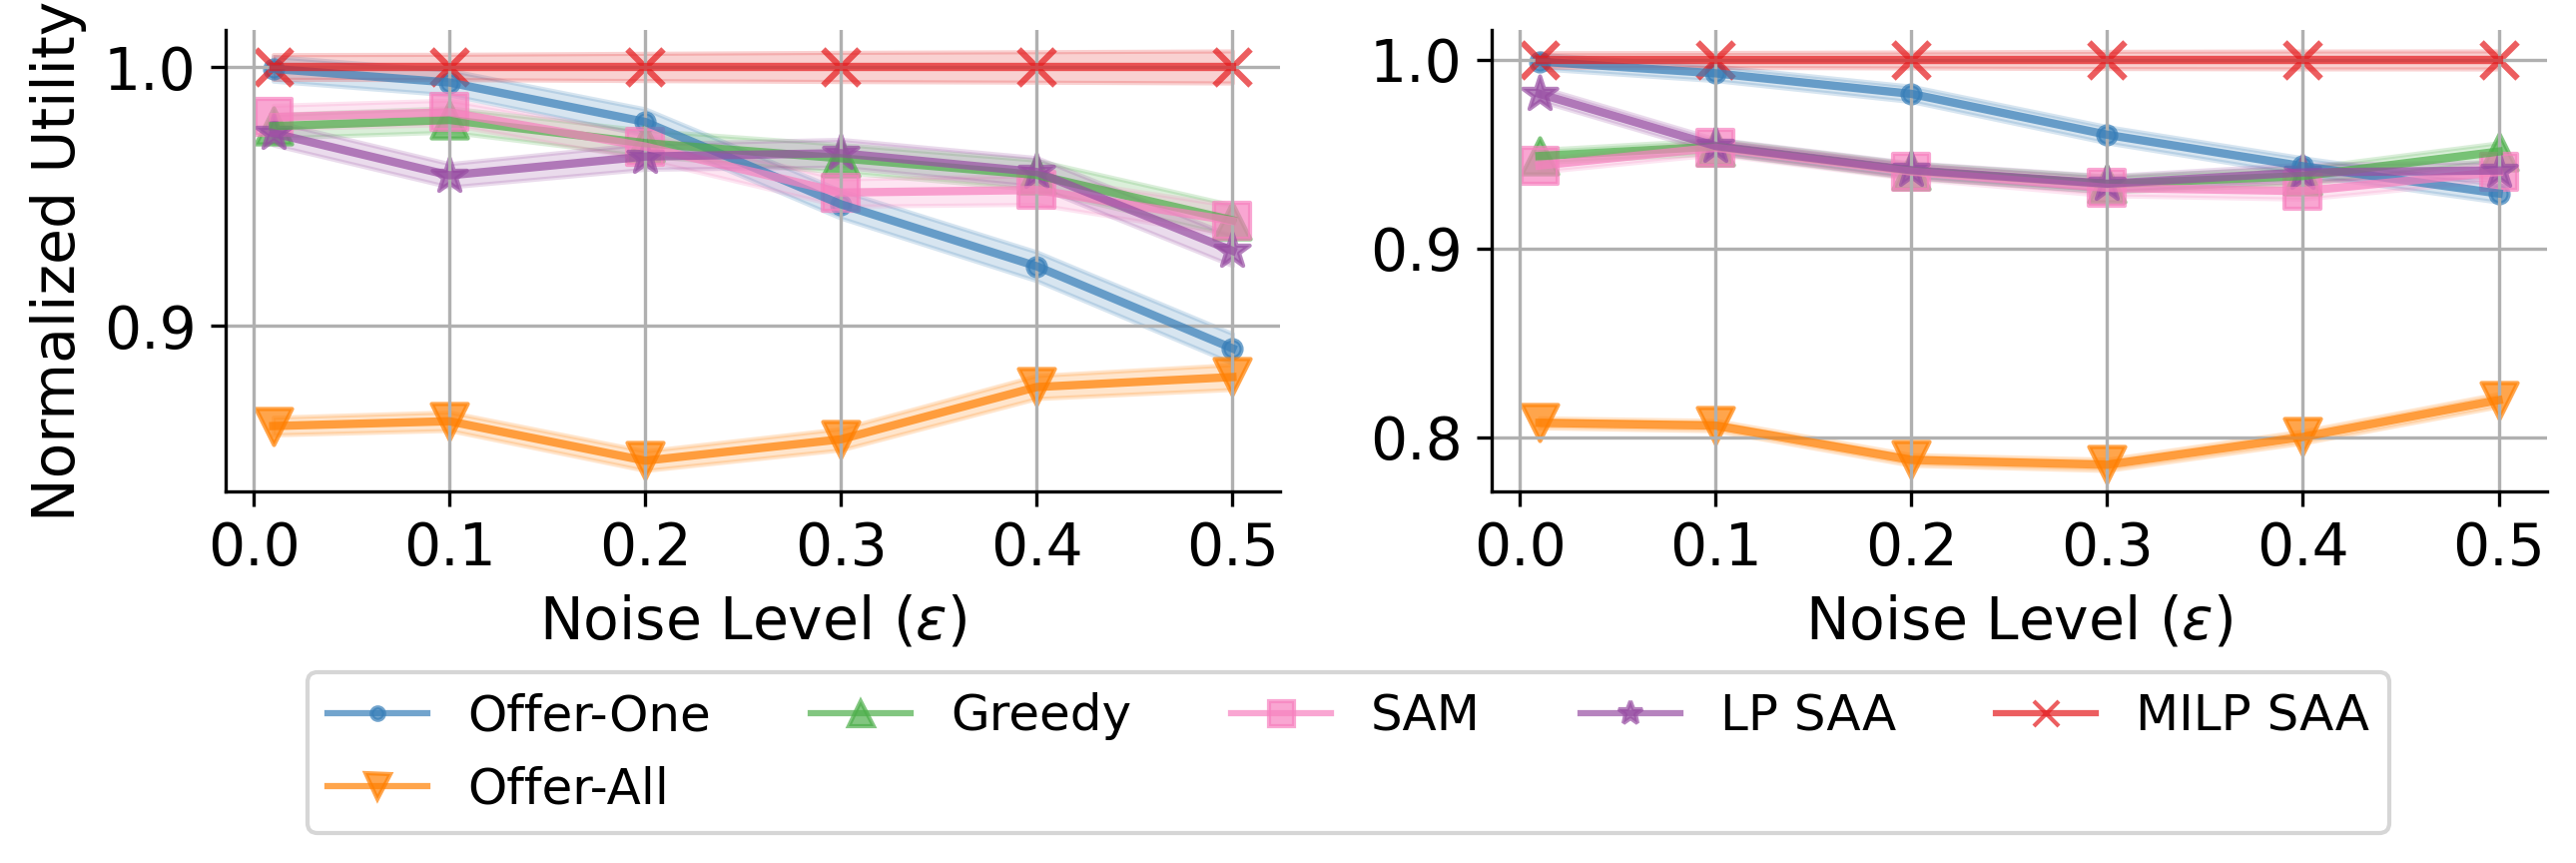

In [11]:
plot_dimensions = (1, 2)
x_labels = [["Noise Level ($\epsilon$)", "Noise Level ($\epsilon$)"]]
y_labels = [["Normalized Utility", ""]]

overall_format = {
    'figsize': (10, 2),
    'style_size': 'paper',
    'hide_spines': True,
    'has_grid': True,
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Plot 1: Patient/Provider Ratio
line_format = {
    'color_palette': 'six_color',
    'linewidth': 2,
}

x_values_noise = [noise_values for _ in methods_full]
y_values_noise = [np.array(noise_avg_utilities[method])/np.array(noise_avg_utilities['full_milp_policy']) for method in methods_full]
y_confidence_noise = [np.array(noise_avg_utilities_std[method])*np.array(noise_avg_utilities[method])/np.array(noise_avg_utilities['full_milp_policy']) for method in methods_full]

plot_line(ax[0][0], x_values_noise, y_values_noise, y_confidence_noise, method_labels_full, line_format)
plot_scatter(ax[0][0], x_values_noise, y_values_noise, [], {'color_palette': 'six_color', 'size': 75})

# Plot 2: Noise
x_values_noise = [noise_values for _ in methods_full]
y_values_noise = [np.array(noise_avg_utilities_large[method])/np.array(noise_avg_utilities_large['full_milp_policy']) for method in methods_full]
y_confidence_noise = [np.array(noise_avg_utilities_std_large[method])*np.array(noise_avg_utilities_large[method])/np.array(noise_avg_utilities_large['full_milp_policy']) for method in methods_full]

plot_line(ax[0][1], x_values_noise, y_values_noise, y_confidence_noise, method_labels_full, line_format)
plot_scatter(ax[0][1], x_values_noise, y_values_noise, [], {'color_palette': 'six_color', 'size': 75})

# Add legend
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper center',
    'ncol': 5,
    'bbox_to_anchor': (0.5, -0.15),
    'show_point': True
}
create_legend(fig, ax, plot_dimensions, legend_format)

fig.savefig("../../results/figures/approximation_factor.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [60]:

# === Plot 1: Patient/Provider Ratio ===
num_patients_values = [800,1200,1600,2000]
num_providers = 700

# Store results for each method
ratio_avg_utilities = {method: [] for method in methods}
ratio_avg_utilities_std = {method: [] for method in methods}

for num_patients in num_patients_values:
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': num_patients,
        'num_providers': num_providers,
        'noise': 0.25, 
        'average_distance': 20.2, 
        'verbose': False
    })
    results = [i for i in results if 'num_samples' not in i['parameters']]

    
    for method in methods:
        utilities_key = f"{method}_patient_utilities"
        utilities = [r[utilities_key][0] for r in results]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        ratio_avg_utilities[method].append(np.mean(all_utilities))
        ratio_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))

# === Plot 2: Noise ===
noise_values = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

# Store results for each method
noise_avg_utilities = {method: [] for method in methods}
noise_avg_utilities_std = {method: [] for method in methods}

for noise in noise_values:
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': 1225,
        'num_providers': 700,
        'noise': noise,
        'average_distance': 20.2,
        'online_scale': 1,
        'verbose': False
    })

    results = [i for i in results if 'num_samples' not in i['parameters']]

    for method in methods:
        utilities_key = f"{method}_patient_utilities"
        utilities = [r[utilities_key][0] for r in results]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        noise_avg_utilities[method].append(np.mean(all_utilities))
        noise_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))
# === Plot 3: Max Shown ===

max_shown = [5,10,25,50,100]

# Store results for each method
max_shown_avg_utilities = {method: [] for method in methods}
max_shown_avg_utilities_std = {method: [] for method in methods}

for m in max_shown:
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': 1225,
        'num_providers': 700,
        'noise': 0.25,
        'average_distance': 20.2,
        'online_scale': 1,
        'max_shown': m, 
        'verbose': False,
    })


    results = [i for i in results if 'num_samples' not in i['parameters']]
    
    for method in methods:
        utilities_key = f"{method}_patient_utilities"
        utilities = [r[utilities_key][0] for r in results if utilities_key in r]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        max_shown_avg_utilities[method].append(np.mean(all_utilities))
        max_shown_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))


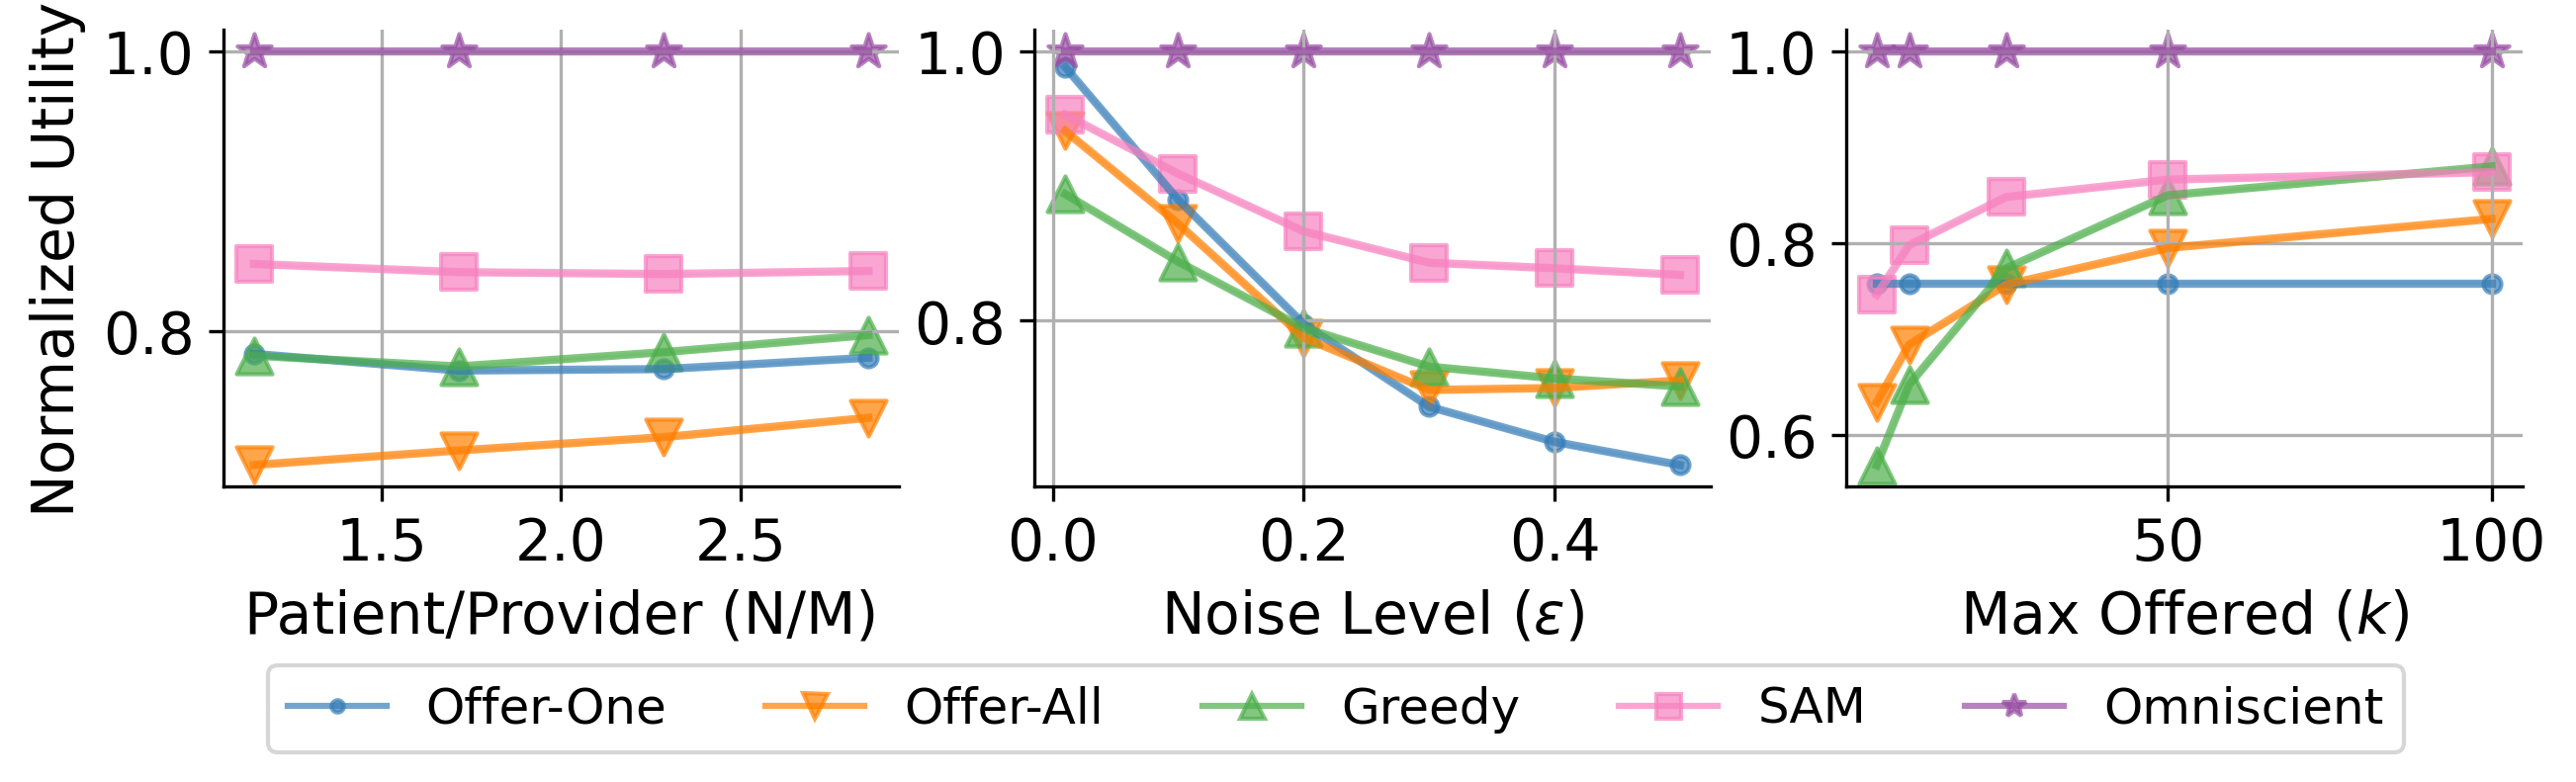

In [35]:
plot_dimensions = (1, 3)
x_labels = [["Patient/Provider (N/M)", "Noise Level ($\epsilon$)","Max Offered ($k$)"]]
y_labels = [["Normalized Utility", "",""]]

# Calculate ratios for x-axis
ratios = [n / num_providers for n in num_patients_values]

overall_format = {
    'figsize': (10, 2),
    'style_size': 'paper',
    'hide_spines': True,
    'has_grid': True,
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Plot 1: Patient/Provider Ratio
line_format = {
    'color_palette': 'six_color',
    'linewidth': 2,
}

x_values_ratio = [ratios for _ in methods]
y_values_ratio = [np.array(ratio_avg_utilities[method])/np.array(ratio_avg_utilities['omniscient_optimal']) for method in methods]
y_confidence_ratio = [np.array(ratio_avg_utilities_std[method])*np.array(ratio_avg_utilities[method])/np.array(ratio_avg_utilities['omniscient_optimal']) for method in methods]

plot_line(ax[0][0], x_values_ratio, y_values_ratio, y_confidence_ratio, method_labels, line_format)
plot_scatter(ax[0][0], x_values_ratio, y_values_ratio, [], {'color_palette': 'six_color', 'size': 75})

# Plot 2: Noise
x_values_noise = [noise_values for _ in methods]
y_values_noise = [np.array(noise_avg_utilities[method])/np.array(noise_avg_utilities['omniscient_optimal']) for method in methods]
y_confidence_noise = [np.array(noise_avg_utilities_std[method])*np.array(noise_avg_utilities[method])/np.array(noise_avg_utilities['omniscient_optimal']) for method in methods]

plot_line(ax[0][1], x_values_noise, y_values_noise, y_confidence_noise, method_labels, line_format)
plot_scatter(ax[0][1], x_values_noise, y_values_noise, [], {'color_palette': 'six_color', 'size': 75})

x_values_shown = [max_shown for _ in methods]
y_values_shown = [np.array(max_shown_avg_utilities[method])/np.array(max_shown_avg_utilities['omniscient_optimal']) for method in methods]
y_confidence_shown = [np.array(max_shown_avg_utilities_std[method])*np.array(max_shown_avg_utilities[method])/np.array(max_shown_avg_utilities['omniscient_optimal']) for method in methods]

plot_line(ax[0][2], x_values_shown, y_values_shown, y_confidence_shown, method_labels, line_format)
plot_scatter(ax[0][2], x_values_shown, y_values_shown, [], {'color_palette': 'six_color', 'size': 75})


# Add legend
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper center',
    'ncol': 5,
    'bbox_to_anchor': (0.5, -0.15),
    'show_point': True
}
create_legend(fig, ax, plot_dimensions, legend_format)

fig.savefig("../../results/figures/ablation_study.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [71]:
val_0 = ratio_avg_utilities[methods[-2]][0]/ratio_avg_utilities['omniscient_optimal'][0],ratio_avg_utilities[methods[-2]][0]/ratio_avg_utilities['greedy'][0],ratio_avg_utilities[methods[-2]][-1]/ratio_avg_utilities['omniscient_optimal'][-1],ratio_avg_utilities[methods[-2]][-1]/ratio_avg_utilities['greedy'][-1]
val_1 = noise_avg_utilities[methods[-2]][0]/noise_avg_utilities['omniscient_optimal'][0], noise_avg_utilities[methods[-2]][-1]/noise_avg_utilities['greedy'][-1]
val_2 = max_shown_avg_utilities[methods[-2]][1]/max_shown_avg_utilities['lp'][1],max_shown_avg_utilities[methods[-2]][1]/max_shown_avg_utilities['offer_everything'][1]
val_2

(np.float64(1.052602177550401), np.float64(1.149188065932866))

In [36]:
average_distance_values = [1, 5, 10, 15, 20, 25, 30]

# Store results for each method
distance_avg_utilities = {method: [] for method in methods}
distance_avg_utilities_std = {method: [] for method in methods}

for avg_dist in average_distance_values:
    print(avg_dist)
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': 1225,
        'num_providers': 700,
        'noise': 0.25,
        'average_distance': avg_dist, 
        'num_samples': 10
    })
    
    for method in methods:
        utilities_key = f"{method}_patient_utilities"
        utilities = [r[utilities_key][0] for r in results]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        distance_avg_utilities[method].append(np.mean(all_utilities))
        distance_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))


num_samples = [1,2,5,10,25]
sample_avg_utilities = {method: [] for method in methods}
sample_avg_utilities_std = {method: [] for method in methods}

for s in num_samples:
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': 1225,
        'num_providers': 700,
        'noise': 0.25,
        'average_distance': 20.2,
        'num_samples': s,
        'verbose': False,
    })
    
    for method in methods:
        utilities_key = f"{method}_patient_utilities"
        utilities = [r[utilities_key][0] for r in results]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        sample_avg_utilities[method].append(np.mean(all_utilities))
        sample_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))

1


5
10
15
20
25
30


In [43]:
plot_dimensions = (1, 2)
x_labels = [["Distance ($\\bar{d}$)", "Samples ($S$)"]]
y_labels = [["Normalized Utility", ""]]

# Calculate ratios for x-axis

overall_format = {
    'figsize': (10, 2),
    'style_size': 'paper',
    'hide_spines': True,
    'has_grid': True,
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Plot 1: Patient/Provider Ratio
line_format = {
    'color_palette': 'six_color',
    'linewidth': 2,
}

x_values_ratio = [average_distance_values for _ in methods]
y_values_ratio = [np.array(distance_avg_utilities[method])/np.array(distance_avg_utilities['omniscient_optimal']) for method in methods]
y_confidence_ratio = [np.array(distance_avg_utilities_std[method])*np.array(distance_avg_utilities[method])/np.array(distance_avg_utilities['omniscient_optimal']) for method in methods]

plot_line(ax[0][0], x_values_ratio, y_values_ratio, y_confidence_ratio, method_labels, line_format)
plot_scatter(ax[0][0], x_values_ratio, y_values_ratio, [], {'color_palette': 'six_color', 'size': 75})

# Plot 2: Noise
x_values_noise = [num_samples for _ in methods]
y_values_noise = [np.array(sample_avg_utilities[method])/np.array(sample_avg_utilities['omniscient_optimal']) for method in methods]
y_confidence_noise = [np.array(sample_avg_utilities_std[method])*np.array(sample_avg_utilities[method])/np.array(sample_avg_utilities['omniscient_optimal']) for method in methods]

plot_line(ax[0][1], x_values_noise, y_values_noise, y_confidence_noise, method_labels, line_format)
plot_scatter(ax[0][1], x_values_noise, y_values_noise, [], {'color_palette': 'six_color', 'size': 75})


# Add legend
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper center',
    'ncol': 5,
    'bbox_to_anchor': (0.5, -0.15),
    'show_point': True
}
create_legend(fig, ax, plot_dimensions, legend_format)

fig.savefig("../../results/figures/ablation_num_samples.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [46]:
max(sample_avg_utilities['greedy_justified_new'])/min(sample_avg_utilities['greedy_justified_new'])

np.float64(1.0217817267107236)

### Choice Plot

In [83]:
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225, 'average_distance': 20.2,'online_scale': 1, 'noise': 0.25, 'verbose': True})


KeyboardInterrupt: 

In [32]:
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225, 'average_distance': 20.2,'online_scale': 1, 'noise': 0.25, 'verbose': True})
all_ratios = [[] for i in range(len(methods))]
all_patient_counts = [[] for i in range(len(methods))]

for k,m in enumerate(methods):
    for seed in results:        
        num_options = seed['{}_options'.format(m)][0]
        all_options = [[len(j) for j in i] for i in num_options]
        
        for i in all_options:
            for j in i:
                all_patient_counts[k].append(j)

for k,m in enumerate(methods):
    for seed in results:        
        for i in range(len(seed['{}_weights'.format(m)][0])):
            for j in range(len(seed['{}_weights'.format(m)][0][i])):
                weights = np.array(seed['{}_weights'.format(m)][0][i][j])
                options = seed['{}_options'.format(m)][0][i][j]
                all_ratios[k].append(np.mean(weights[options])/np.mean(weights[np.argsort(weights)[-len(options):]]))

In [33]:
plot_dimensions = (5, 2)
sup_y_label = ""

y_lim = [[[0,0.4],[0,4.5]] for i in range(5)]
y_ticks = [[[[0.0,0.2,0.4],[0.0,0.2,0.4]],[[0,2,4],[0,2,4]]] for i in range(5)]

y_lim[0][0] = y_lim[4][0] = [0,5.5]
y_ticks[0][0] = y_ticks[4][0] = [[0,5],[0.0,5.0]]

overall_format = {
    'figsize': (10,7),
    'style_size': 'paper',
    'hide_spines': True,
    'has_grid': True,
    'x_lim': [[[0,25],[0,1]] for i in range(5)],
    'y_lim': y_lim,
    'y_ticks': y_ticks 
}

fig, ax = create_axes(plot_dimensions, overall_format, sup_y_label=sup_y_label,y_labels=[[method_labels[i],""] for i in range(5)],
                      titles=[["#Choices","Fraction Top-$L_{i}$ Utility"],["",""],["",""],["",""],["",""]])

# --------------------------------------
# Plot KDEs (or histograms if discrete)
# --------------------------------------
for i in range(len(methods)):
    a = ax[i][1]

    # KDE
    sns.kdeplot(
        all_ratios[i],
        ax=a,
        fill=True,
        color="#4C72B0",
        label="Providers"
    )


    sns.kdeplot(all_patient_counts[i], ax=ax[i][0], fill=True, color="#4C72B0", label="Patients")

# Optionally, if your data is integer and not large, histograms may be clearer:
# ax[0][0].hist(all_patient_counts, bins=np.arange(0, max(all_patient_counts)+1)-0.5, color="#4C72B0", alpha=0.7)
# ax[0][1].hist(all_provider_counts, bins=np.arange(0, max(all_provider_counts)+1)-0.5, color="#55A868", alpha=0.7)

# --------------------------------------
# Legend and save
# --------------------------------------
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper right',
    'ncol': 2,
    'bbox_to_anchor': (0.95, -0.05),
}

plt.tight_layout()
fig.savefig("../../results/figures/assortment_marginals_real_comparison.pdf", dpi=300, bbox_inches="tight")
plt.show()


In [79]:
[np.mean(i) for i in all_patient_counts],[np.mean(i) for i in all_ratios]

([np.float64(1.423764172335601),
  np.float64(9.511921995464853),
  np.float64(6.078269387755102),
  np.float64(10.210024489795918),
  np.float64(1.5714285714285714)],
 [np.float64(0.5344696938843202),
  np.float64(0.22607111168850283),
  np.float64(0.4593220416742214),
  np.float64(0.4246996506293834),
  np.float64(0.49809831179782554)])

### Fairness

In [49]:
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225, 'average_distance': 20.2, 'noise': 0.25,'online_scale': 1, 'verbose': False})

def calculate_zipcode_metrics(method):
    """Calculate match rate and average utility by zipcode for a method"""
    matches_by_zipcode = {}
    utility_by_zipcode = {}
    num_patients = 1225
    num_providers = 700
    
    # Get data for this method
    utilities_key = f"{method}_patient_utilities"
    chosen_providers_key = f"{method}_chosen_providers"
    for r in results:
        params = r['parameters']
        patient_file = f"../../data/patient_data_{params['seed']}_{1225}_{700}_comorbidity.json"
        provider_file = f"../../data/provider_data_{params['seed']}_{1225}_{700}_comorbidity.json"

        with open(patient_file, 'r') as f:
            patient_data = json.load(f)
        with open(provider_file, 'r') as f:
            provider_data = json.load(f)


        # Load patient data to get zipcode mapping
        patient_file = f"../../data/patient_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"
        with open(patient_file, 'r') as f:
            patient_data = json.load(f)

        # Get zipcodes for each patient
        patient_zipcodes = [p['location'] for p in patient_data]

        utilities = r[utilities_key]
        chosen_providers = r[chosen_providers_key]
        # For each seed, trial, patient
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                for patient_idx in range(len(utilities[seed_idx][trial_idx])):
                    utility = utilities[seed_idx][trial_idx][patient_idx]
                    provider = chosen_providers[seed_idx][trial_idx][patient_idx]
                    zipcode = patient_zipcodes[patient_idx]
                    
                    if zipcode not in matches_by_zipcode:
                        matches_by_zipcode[zipcode] = []
                        utility_by_zipcode[zipcode] = []
                    
                    # Patient matched if provider is in [0, num_providers-1]
                    matched = (provider >= 0 and provider < num_providers)
                    matches_by_zipcode[zipcode].append(1 if matched else 0)
                    utility_by_zipcode[zipcode].append(utility)
    
    # Calculate averages
    match_rate = {z: np.mean(matches_by_zipcode[z]) for z in matches_by_zipcode}
    avg_utility = {z: np.mean(utility_by_zipcode[z]) for z in utility_by_zipcode}
    
    return match_rate, avg_utility, patient_data, provider_data
match_rate_omni, utility_omni, patient_data,provider_data = calculate_zipcode_metrics('lp')

# Load CT zipcode shapefile
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Add data to geodataframe
ct_zipcodes["match_rate"] = [match_rate_omni.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["avg_utility"] = [utility_omni.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
patient_zips = [get_zip(p["location"]) for p in patient_data]


patient_zips = [get_zip(p["location"]) for p in patient_data]
patient_counts = pd.Series(patient_zips).value_counts().rename_axis("ZCTA5CE10").reset_index(name="patients")

patient_counts_sorted = patient_counts.sort_values('patients')
zipcodes_sorted = patient_counts_sorted['ZCTA5CE10']

# --- Step 2: Build rolling averages for each method ---
window_size = 25  # you can tweak this
rolling_match_rates = {}
for method in methods:
    match_rate_map = calculate_zipcode_metrics(method)[0]  # {zipcode: match_rate}
    # Extract rates in patient-count order
    rates_sorted = np.array([match_rate_map[z] for z in zipcodes_sorted])
    # Compute rolling average
    rolling_avg = pd.Series(rates_sorted).rolling(window=window_size, min_periods=1, center=True).mean().to_numpy()
    rolling_match_rates[method] = rolling_avg

match_rate_by_method = {}
for method in methods:  
    match_rate_by_method[method] = list(calculate_zipcode_metrics(method)[0].values())


In [54]:
rolling_match_rates['greedy_justified_new'][224//4]/rolling_match_rates['omniscient_optimal'][224//4]

np.float64(1.172581256453293)

/tmp/ipykernel_2390627/1992280616.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


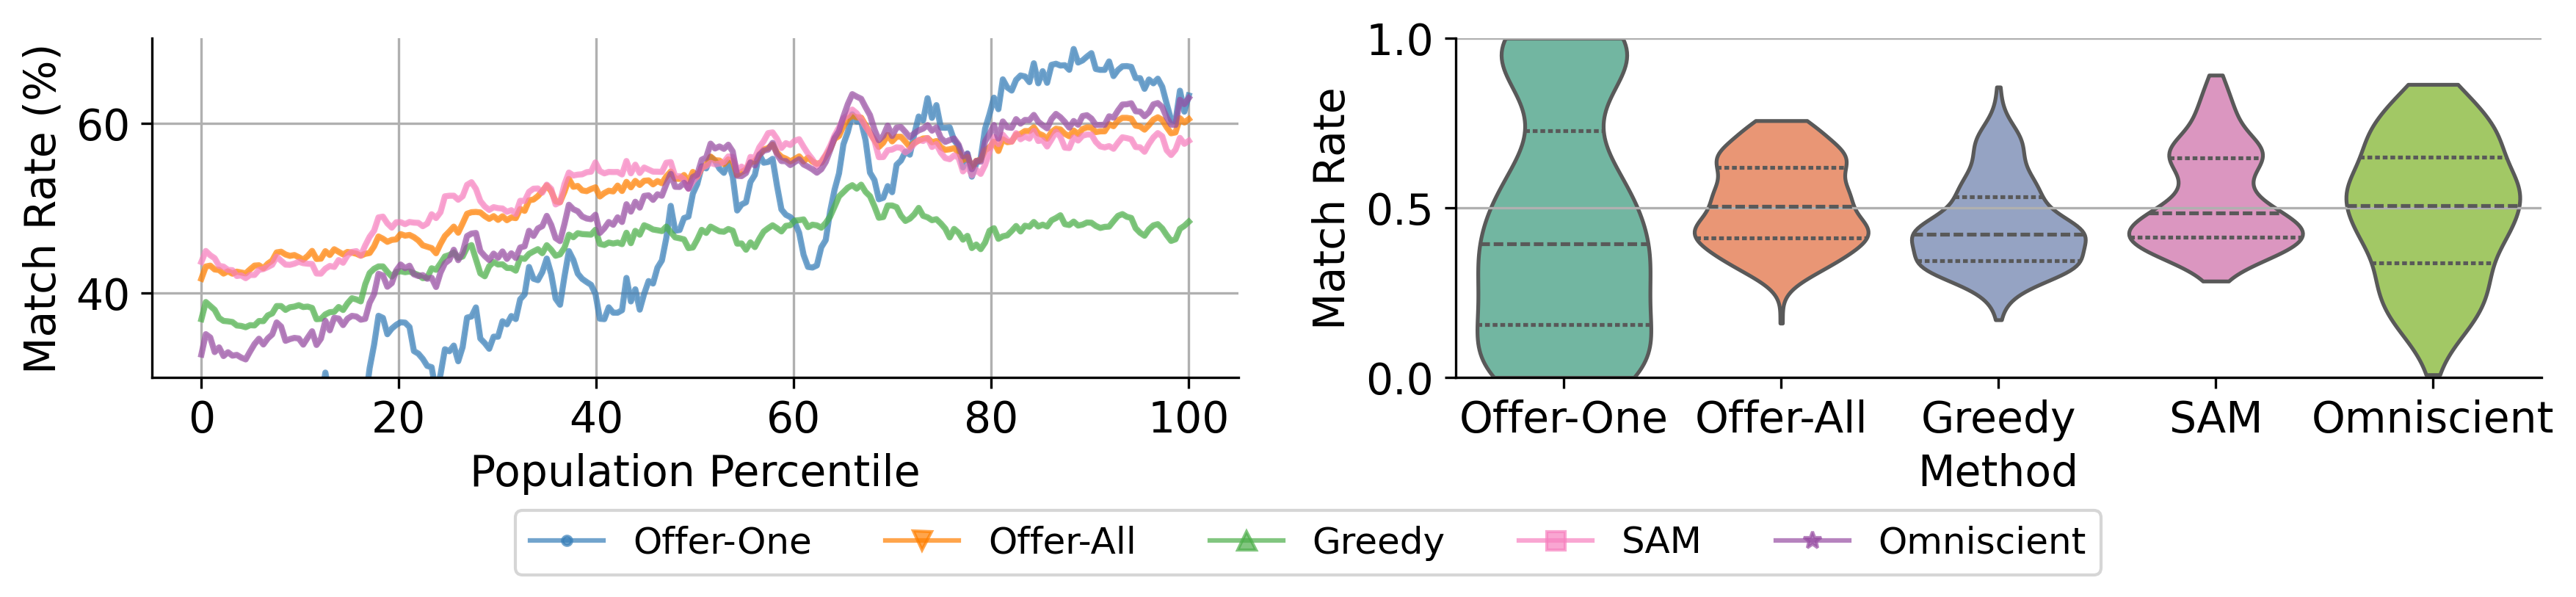

In [55]:
num_zipcodes = len(zipcodes_sorted)
zipcode_percentile = np.linspace(0, 100, num_zipcodes)

# --- Step 4: Plotting ---
plot_dimensions = (1, 2)
x_labels = [["Population Percentile",""]]
y_labels = [["Match Rate (%)",""]]

overall_format = {
    'figsize': (14, 2),
    'style_size': 'paper',
    'hide_spines': True,
    'has_grid': True,
    'y_lim': [[[30, 70],[0,1]]]  # adjust if your match rate is 0-1 or 0-100
}

line_format = {
    'color_palette': 'six_color',
    'linewidth': 2,
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Prepare data for plotting
x_values = [zipcode_percentile for _ in methods]
y_values = [rolling_match_rates[m]*100 for m in methods]

# No confidence interval here; if you want, you could compute rolling std similarly
y_confidence = [np.zeros_like(rolling_match_rates[m]) for m in methods]

# Plot lines
plot_line(ax[0][0], x_values, y_values, y_confidence, method_labels, line_format)

methods = list(match_rate_by_method.keys())

df = pd.DataFrame({
    'Match Rate': [rate for method in methods for rate in match_rate_by_method[method]],
    'Method': [method_labels[i] for i, method in enumerate(methods) for _ in match_rate_by_method[method]]
})

sns.violinplot(
    ax=ax[0][1],
    x='Method',
    y='Match Rate',
    data=df,
    inner='quartile',
    palette='Set2',
    cut=0
)


# Legend
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper center',
    'ncol': 5,
    'bbox_to_anchor': (0.5, -0.15),
    'show_point': True
}
create_legend(fig, ax, plot_dimensions, legend_format)

# Save / show
fig.savefig("../../results/figures/fairness_distribution.pdf", dpi=300, bbox_inches='tight')

plt.show()


In [85]:
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225, 'average_distance': 20.2, 'noise': 0.25, 'online_scale': 1, 'verbose': False})

# For colorblind-friendly palette (blue, orange, green, pink)
color_palette = [(0.216, 0.494, 0.722, 0.7),
                (1.0, 0.498, 0.0, 0.7),
                (0.302, 0.686, 0.29, 0.7),
                (0.969, 0.506, 0.749, 0.7),
                (0.596, 0.306, 0.639, 0.7),
                (0.894, 0.102, 0.11, 0.7)]
markers = [".","v","^","s","*","x"]

# --------------------------------------
# Helper: compute metrics per method
# --------------------------------------
def compute_metrics(method):
    key_util = f"{method}_patient_utilities"
    key_match = f"{method}_chosen_providers"
    utilities = [r[key_util] for r in results]
    chosen_providers = [r[key_match] for r in results]
    num_providers = results[0]['parameters']['num_providers']

    match_rates = []
    avg_utils = []
    fairness_std = []
    fairness_minmax = []
    fairness_min = []

    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            util_arr = np.array(utilities[seed_idx][trial_idx])
            chosen_arr = np.array(chosen_providers[seed_idx][trial_idx])

            # Match indicator per patient
            matched = ((chosen_arr >= 0) & (chosen_arr < num_providers)).astype(int)

            # Per-patient "match quality" = utility if matched else 0
            match_quality = util_arr

            # Store per-trial metrics
            match_rates.append(np.mean(matched))
            avg_utils.append(np.mean(match_quality))
            fairness_std.append(np.std(match_quality))
            fairness_minmax.append(np.percentile(match_quality, 75) - np.percentile(match_quality, 25))
            fairness_min.append(np.percentile(match_quality, 25))

    # Average across all trials and seeds
    return {
        "match_rate": np.mean(match_rates),
        "avg_utility": np.mean(avg_utils),
        "fairness_std": np.mean(fairness_std),
        "fairness_minmax": np.mean(fairness_minmax),
        "fairness_min": np.mean(fairness_min),
    }

# Compute for all methods
metrics = {m: compute_metrics(m) for m in methods}


In [87]:
metrics['greedy_justified_new']

{'match_rate': np.float64(0.5619156462585034),
 'avg_utility': np.float64(0.6006453911324227),
 'fairness_std': np.float64(0.34663816191307384),
 'fairness_minmax': np.float64(0.6842424654285385),
 'fairness_min': np.float64(0.2667962157269978)}

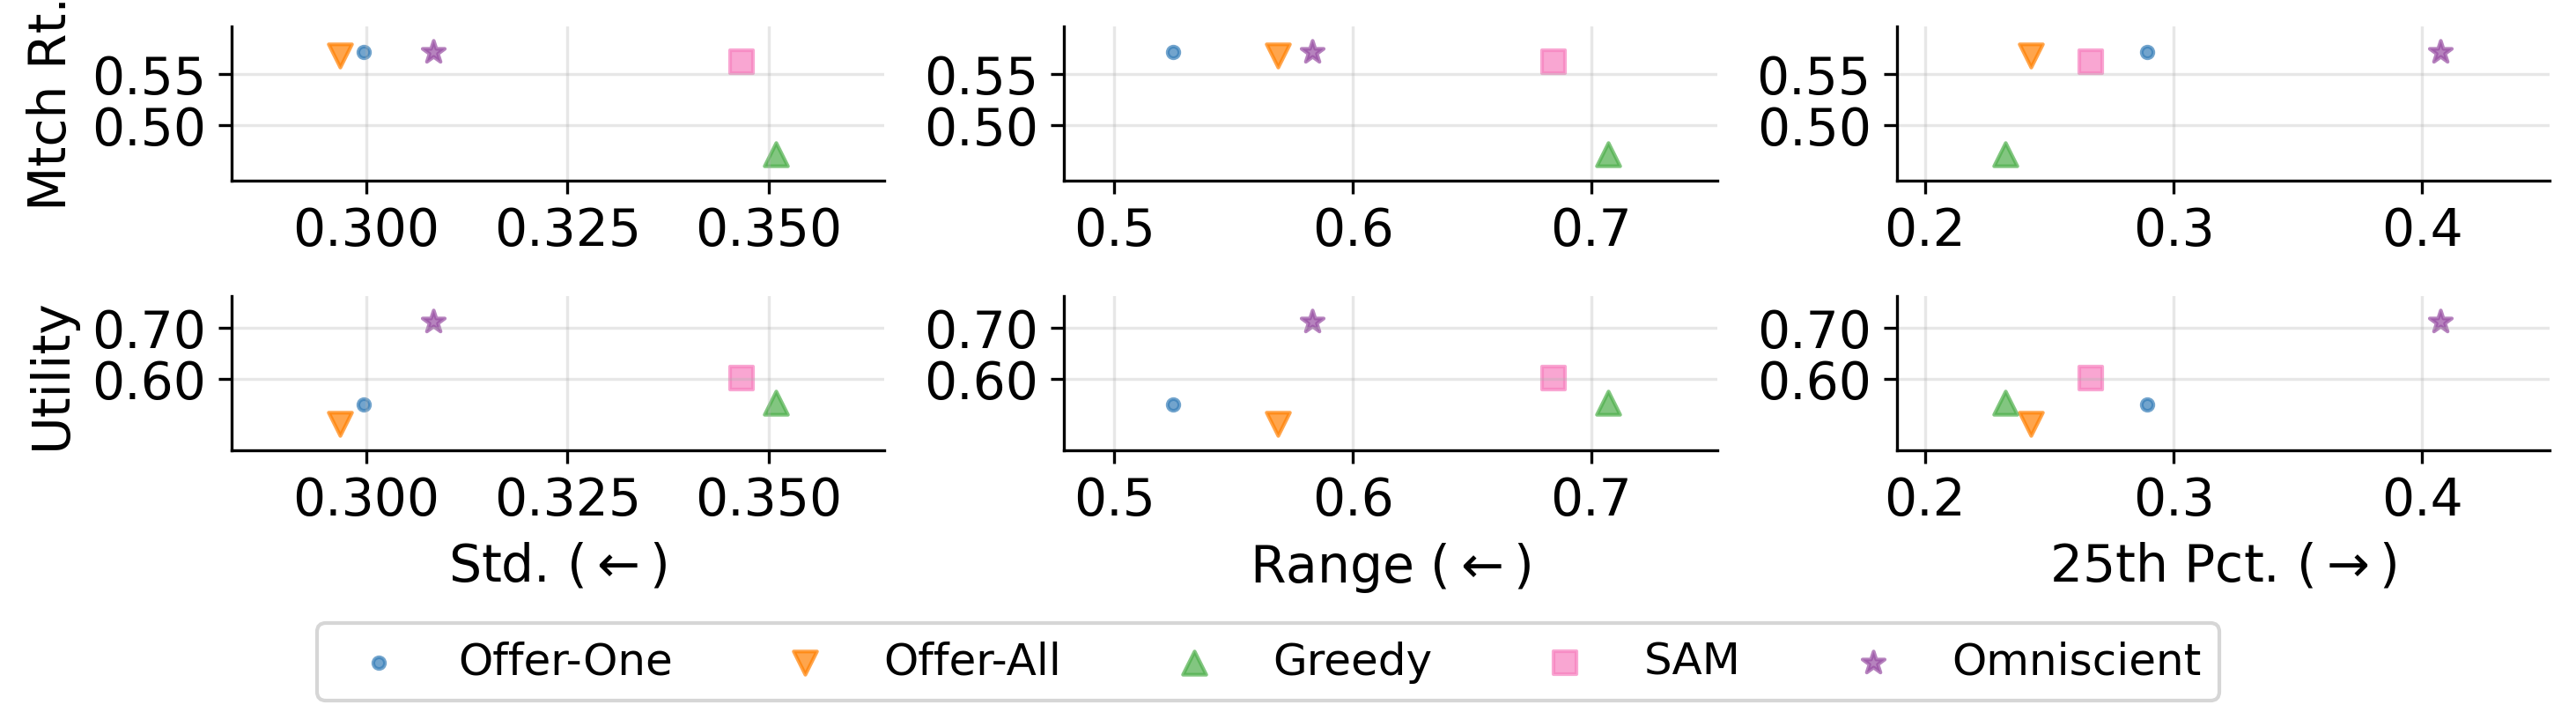

In [32]:
plot_dimensions = (2, 3)
x_labels = [
    ["", "", ""],
    ["Std. ($\\leftarrow$)", "Range ($\\leftarrow$)", "25th Pct. ($\\rightarrow$)"],
]
y_labels = [
    ["Mtch Rt.", "", ""],
    ["Utility", "", ""],
]
sup_y_label = ""
fairness_metrics = ["fairness_std", "fairness_minmax", "fairness_min"]
y_metrics = ["match_rate", "avg_utility"]

# Helper to compute padded limits
def padded_limits(values, pad_frac=0.25, min_pad=0.05):
    vmin, vmax = np.min(values), np.max(values)
    if vmax == vmin:
        margin = min_pad
    else:
        margin = pad_frac * (vmax - vmin)
    return [vmin - margin, vmax + margin]

# Compute base per-metric limits
x_limits_dict = {m: padded_limits([metrics[k][m] for k in methods]) for m in fairness_metrics}
y_limits_dict = {m: padded_limits([metrics[k][m] for k in methods]) for m in y_metrics}

# Build 2×3×2 list structure
x_lims = [[[x_limits_dict[m] for m in fairness_metrics] for _ in range(2)]]
y_lims = [[[y_limits_dict[m]] * 3 for m in y_metrics]]

# Expand properly to match your function’s (2,3,2) indexing
x_lims = [[ [x_limits_dict[metric] for metric in fairness_metrics] for _ in range(2) ]]
x_lims = x_lims[0]  # (2x3x2) nested list form
y_lims = [ [y_limits_dict[y_metric] for _ in fairness_metrics] for y_metric in y_metrics ]




overall_format = {
    'figsize': (10, 2.75),
    'style_size': 'paper',
    'hide_spines': True,
    'x_lim': x_lims,
    'y_lim': y_lims,
    'has_grid': True,
    'y_ticks': [[[[0.5,0.55],["0.50","0.55"]] for i in range(3)],[[[0.6,0.7],["0.60","0.70"]]  for i in range(3)] ]
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels, sup_y_label=sup_y_label)

# --------------------------------------
# Scatter plots
# --------------------------------------
fairness_metrics = ["fairness_std", "fairness_minmax", "fairness_min"]

for i_row, y_metric in enumerate(["match_rate", "avg_utility"]):
    for i_col, x_metric in enumerate(fairness_metrics):
        for i_method, method in enumerate(methods):
            ax[i_row][i_col].scatter(
                metrics[method][x_metric],
                metrics[method][y_metric],
                color=color_palette[i_method],
                marker=markers[i_method],
                s=40,
                label=method_labels[i_method]
            )

        ax[i_row][i_col].grid(True, alpha=0.3)

# --------------------------------------
# Legend (global)
# --------------------------------------
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper center',
    'ncol': 5,
    'bbox_to_anchor': (0.5, 0.1)
}
create_legend(fig, ax, plot_dimensions, legend_format)

# --------------------------------------
# Save + show
# --------------------------------------
plt.tight_layout()
fig.savefig("../../results/figures/fairness_plot.pdf", dpi=300, bbox_inches='tight')
plt.show()


### MSOM Plots

In [20]:
results = get_results_matching_parameters("baseline", "", {'num_patients': 1225,'average_distance': 20.2, 'noise': 0.25,'online_scale': 1, 'verbose': False})

# Method names

# Calculate average utility per patient for each method
avg_utilities = []
std_utilities = []

for method in methods:
    key = f"{method}_patient_utilities"
    # Flatten: [seeds][trials][patients] -> all patient utilities
    all_patient_utils = []
    for i in range(len(results)):
        for trial in results[i][key][0]:
            all_patient_utils.extend(trial)
    
    # Calculate mean and std
    avg_utilities.append(np.mean(all_patient_utils))
    std_utilities.append(np.std(all_patient_utils) / np.sqrt(len(all_patient_utils)))  # Standard error

In [22]:
avg_utilities[3]/np.max(avg_utilities[:2]),avg_utilities[3]/avg_utilities[4],np.max(avg_utilities[:2])/avg_utilities[4]

(np.float64(0.8112468430056881),
 np.float64(0.5979850488547181),
 np.float64(0.7371184911354106))

In [23]:
plot_dimensions = (1, 1)
x_labels = [[""]]  # Remove x-label since bar labels are self-explanatory
y_labels = [["Utility"]]
overall_format = {
    'figsize': (8, 1.2),  # Slightly wider for better spacing
    'style_size': 'paper',
    'hide_spines': True,
    'x_ticks': [[[[], []]]],
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Bar plot with different colors
bar_format = {
    'style_size': 'paper',
    'color_palette': 'six_color',  # Different colors for each method
    'label_rotation': 0,
    'bar_width': 0.5  # Good balance between width and spacing,
}

x_groups = [0, 1, 2, 3]
plot_bar(ax[0][0], x_groups, avg_utilities, std_utilities, method_labels, bar_format)
ax[0][0].hlines(avg_utilities[-1],-0.25,1.75,label="Omniscient",color="red",linestyle="--")

legend_format = {'style_size': style_size,'type': 'is_global', 'loc': 'upper right', 'ncol': 5, 'bbox_to_anchor': (0.95,-0.15)}

create_legend(fig,ax,plot_dimensions,legend_format)
fig.savefig("../../results/figures/basics_comparison.pdf", dpi=300, bbox_inches='tight')


In [26]:
original_match_rate = ct_zipcodes[ct_zipcodes["ZCTA5CE10"] == "06415"]['match_rate']
original_match_quality = ct_zipcodes[ct_zipcodes["ZCTA5CE10"] == "06415"]['avg_utility']

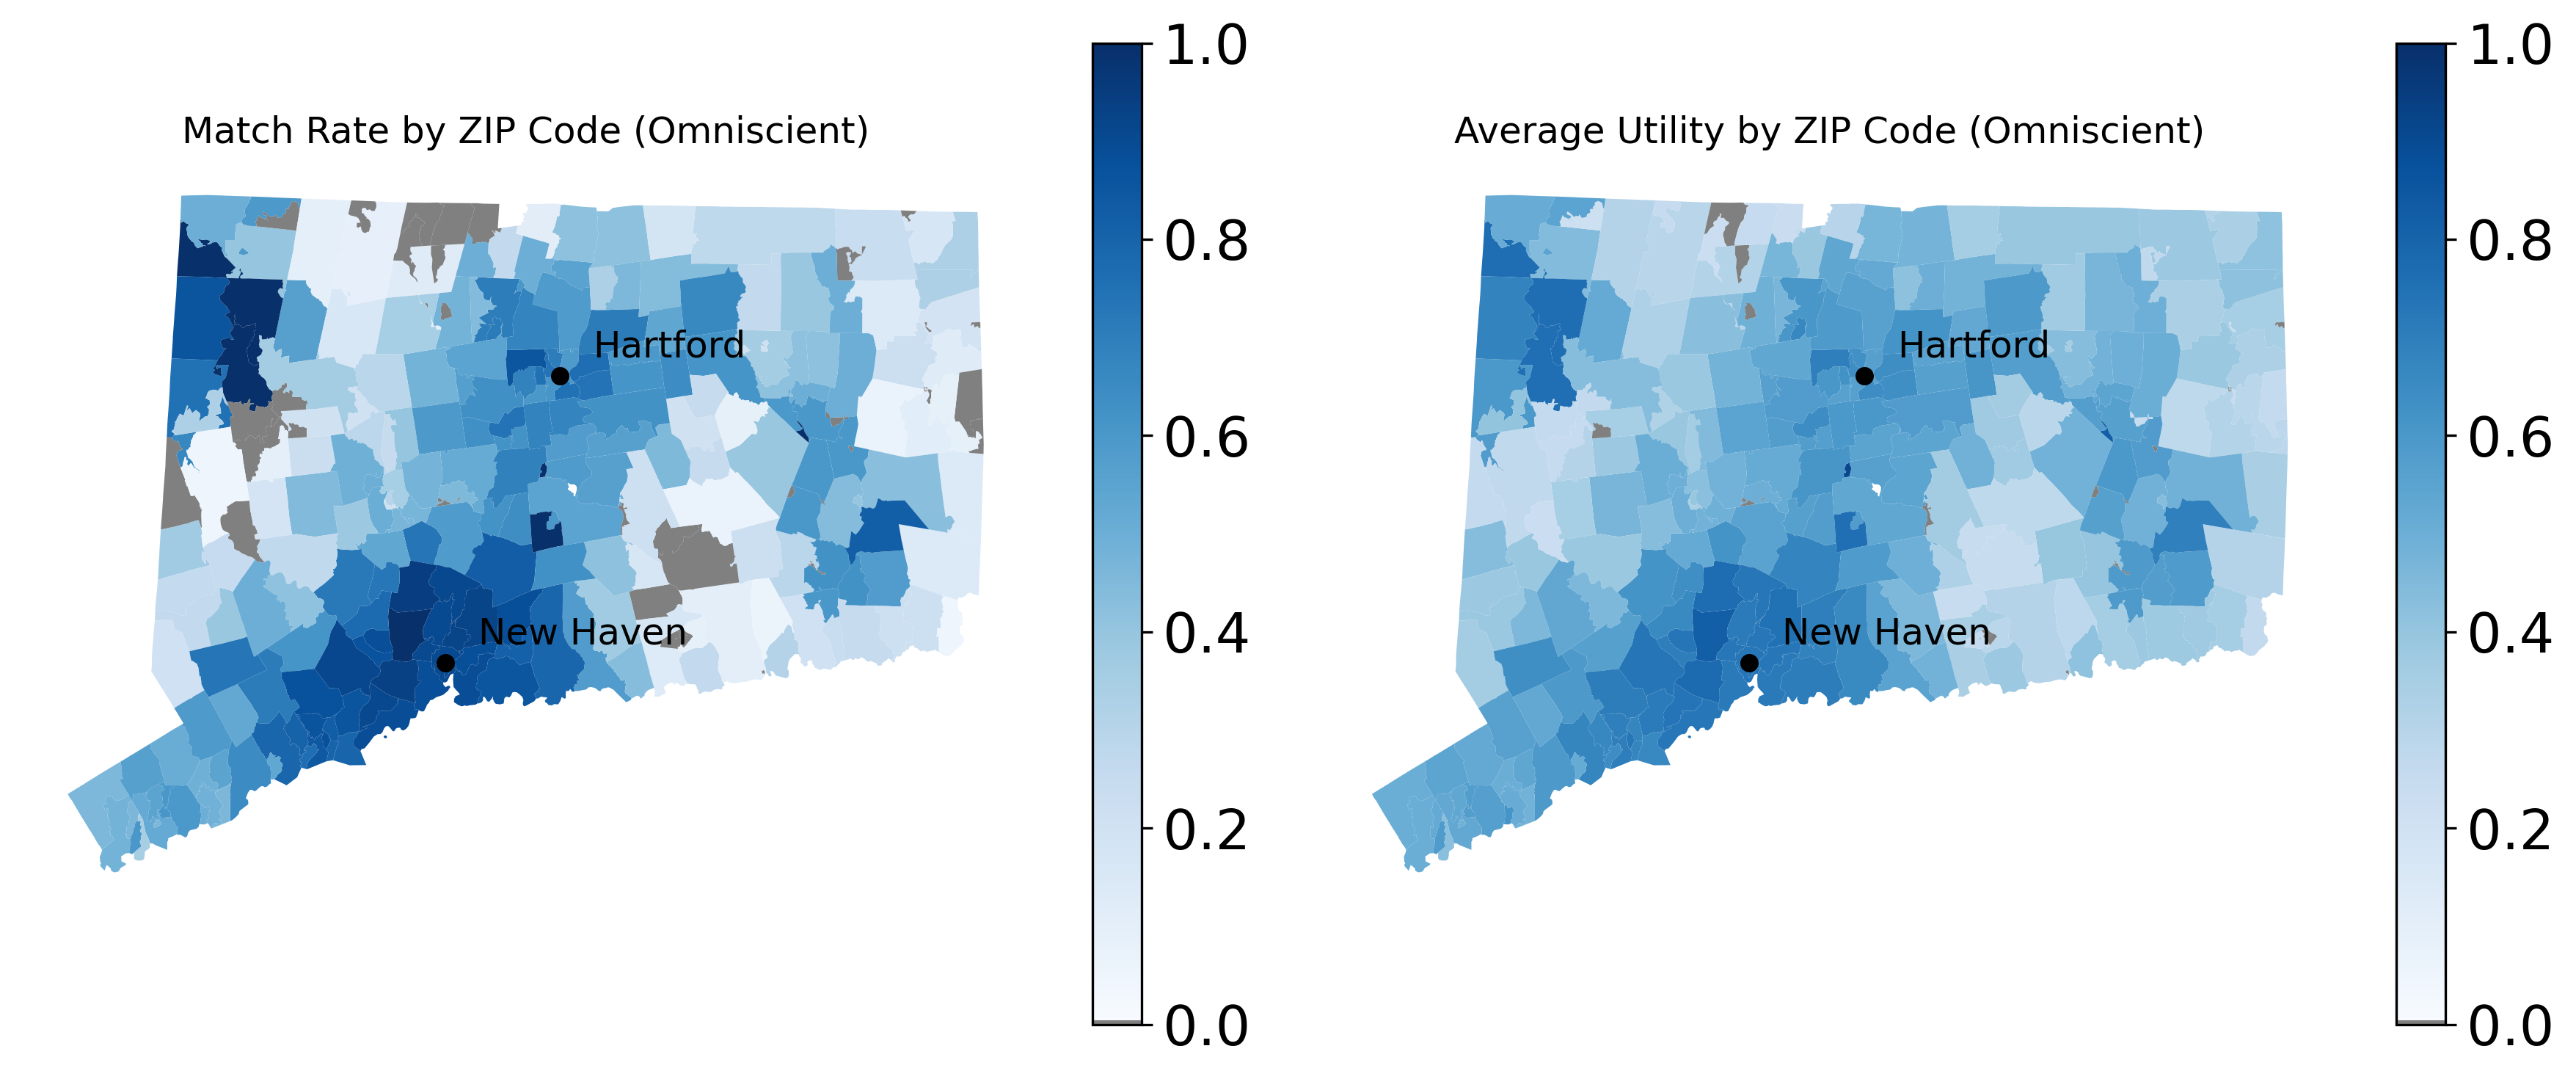

In [27]:
cmap_blue_red = mcolors.ListedColormap(
    ["grey"] + plt.cm.Blues(np.linspace(0, 1, 256)).tolist()
)


# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Match Rate (0 to 1)
ct_zipcodes.plot(column="match_rate", ax=axes[0], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"})
axes[0].set_title("Match Rate by ZIP Code (Omniscient)")
axes[0].axis('off')

# Plot 2: Average Utility (0 to 1)
ct_zipcodes.plot(column="avg_utility", ax=axes[1], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"})
axes[1].set_title("Average Utility by ZIP Code (Omniscient)")
axes[1].axis('off')

hartford_coords = (41.7637, -72.6851)  # Hartford, CT (latitude, longitude)
newhaven_coords = (41.3083, -72.9279)  # New Haven, CT (latitude, longitude)

for i in range(2):
# Plot dots for Hartford and New Haven
    axes[i].scatter(hartford_coords[1], hartford_coords[0], color="black", s=25, zorder=5)  # Hartford
    axes[i].scatter(newhaven_coords[1], newhaven_coords[0], color="black", s=25, zorder=5)  # New Haven

    axes[i].text(hartford_coords[1] + 0.07, hartford_coords[0] + 0.03, "Hartford", color="black", fontsize=12, zorder=6)
    axes[i].text(newhaven_coords[1] + 0.07, newhaven_coords[0] + 0.03, "New Haven", color="black", fontsize=12, zorder=6)


plt.tight_layout()
fig.savefig("../../results/figures/geographic_analysis_lp.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [28]:
match_rate_omni, utility_omni, patient_data,provider_data = calculate_zipcode_metrics('greedy_justified')

# Load CT zipcode shapefile
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Add data to geodataframe
ct_zipcodes["match_rate"] = [match_rate_omni.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["avg_utility"] = [utility_omni.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
patient_zips = [get_zip(p["location"]) for p in patient_data]
patient_counts = pd.Series(patient_zips).value_counts().rename_axis("ZCTA5CE10").reset_index(name="patients")
provider_zips = [get_zip(p["ZIP Code"]) for p in provider_data]

# Count providers per ZIP
provider_counts = pd.Series(provider_zips).value_counts().rename_axis("ZCTA5CE10").reset_index(name="providers")
ct_zipcodes = ct_zipcodes.merge(patient_counts, how="left", on="ZCTA5CE10")
ct_zipcodes = ct_zipcodes.merge(provider_counts, how="left", on="ZCTA5CE10")
ct_zipcodes["patients"] = ct_zipcodes["patients"].fillna(0).astype(int)
ct_zipcodes["providers"] = ct_zipcodes["providers"].fillna(0).astype(int)
ct_zipcodes["ratio"] = ct_zipcodes["providers"] / ct_zipcodes["patients"].replace(0, pd.NA)
ct_zipcodes["ratio"] = ct_zipcodes["ratio"].fillna(0)

/tmp/ipykernel_1876262/1895608063.py:20: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ct_zipcodes["ratio"] = ct_zipcodes["ratio"].fillna(0)


In [29]:
cutoff = ct_zipcodes["patients"].quantile(0.5)

avg_match_rate = ct_zipcodes.loc[
    ct_zipcodes["patients"] <= cutoff, "match_rate"
].mean()
avg_match_rate

np.float64(0.3456103822032365)

In [30]:
new_match_rate = ct_zipcodes[ct_zipcodes["ZCTA5CE10"] == "06415"]['match_rate']
new_match_quality = ct_zipcodes[ct_zipcodes["ZCTA5CE10"] == "06415"]['avg_utility']

In [31]:
original_match_rate,new_match_rate

(233    0.068966
 Name: match_rate, dtype: float64,
 233    0.517241
 Name: match_rate, dtype: float64)

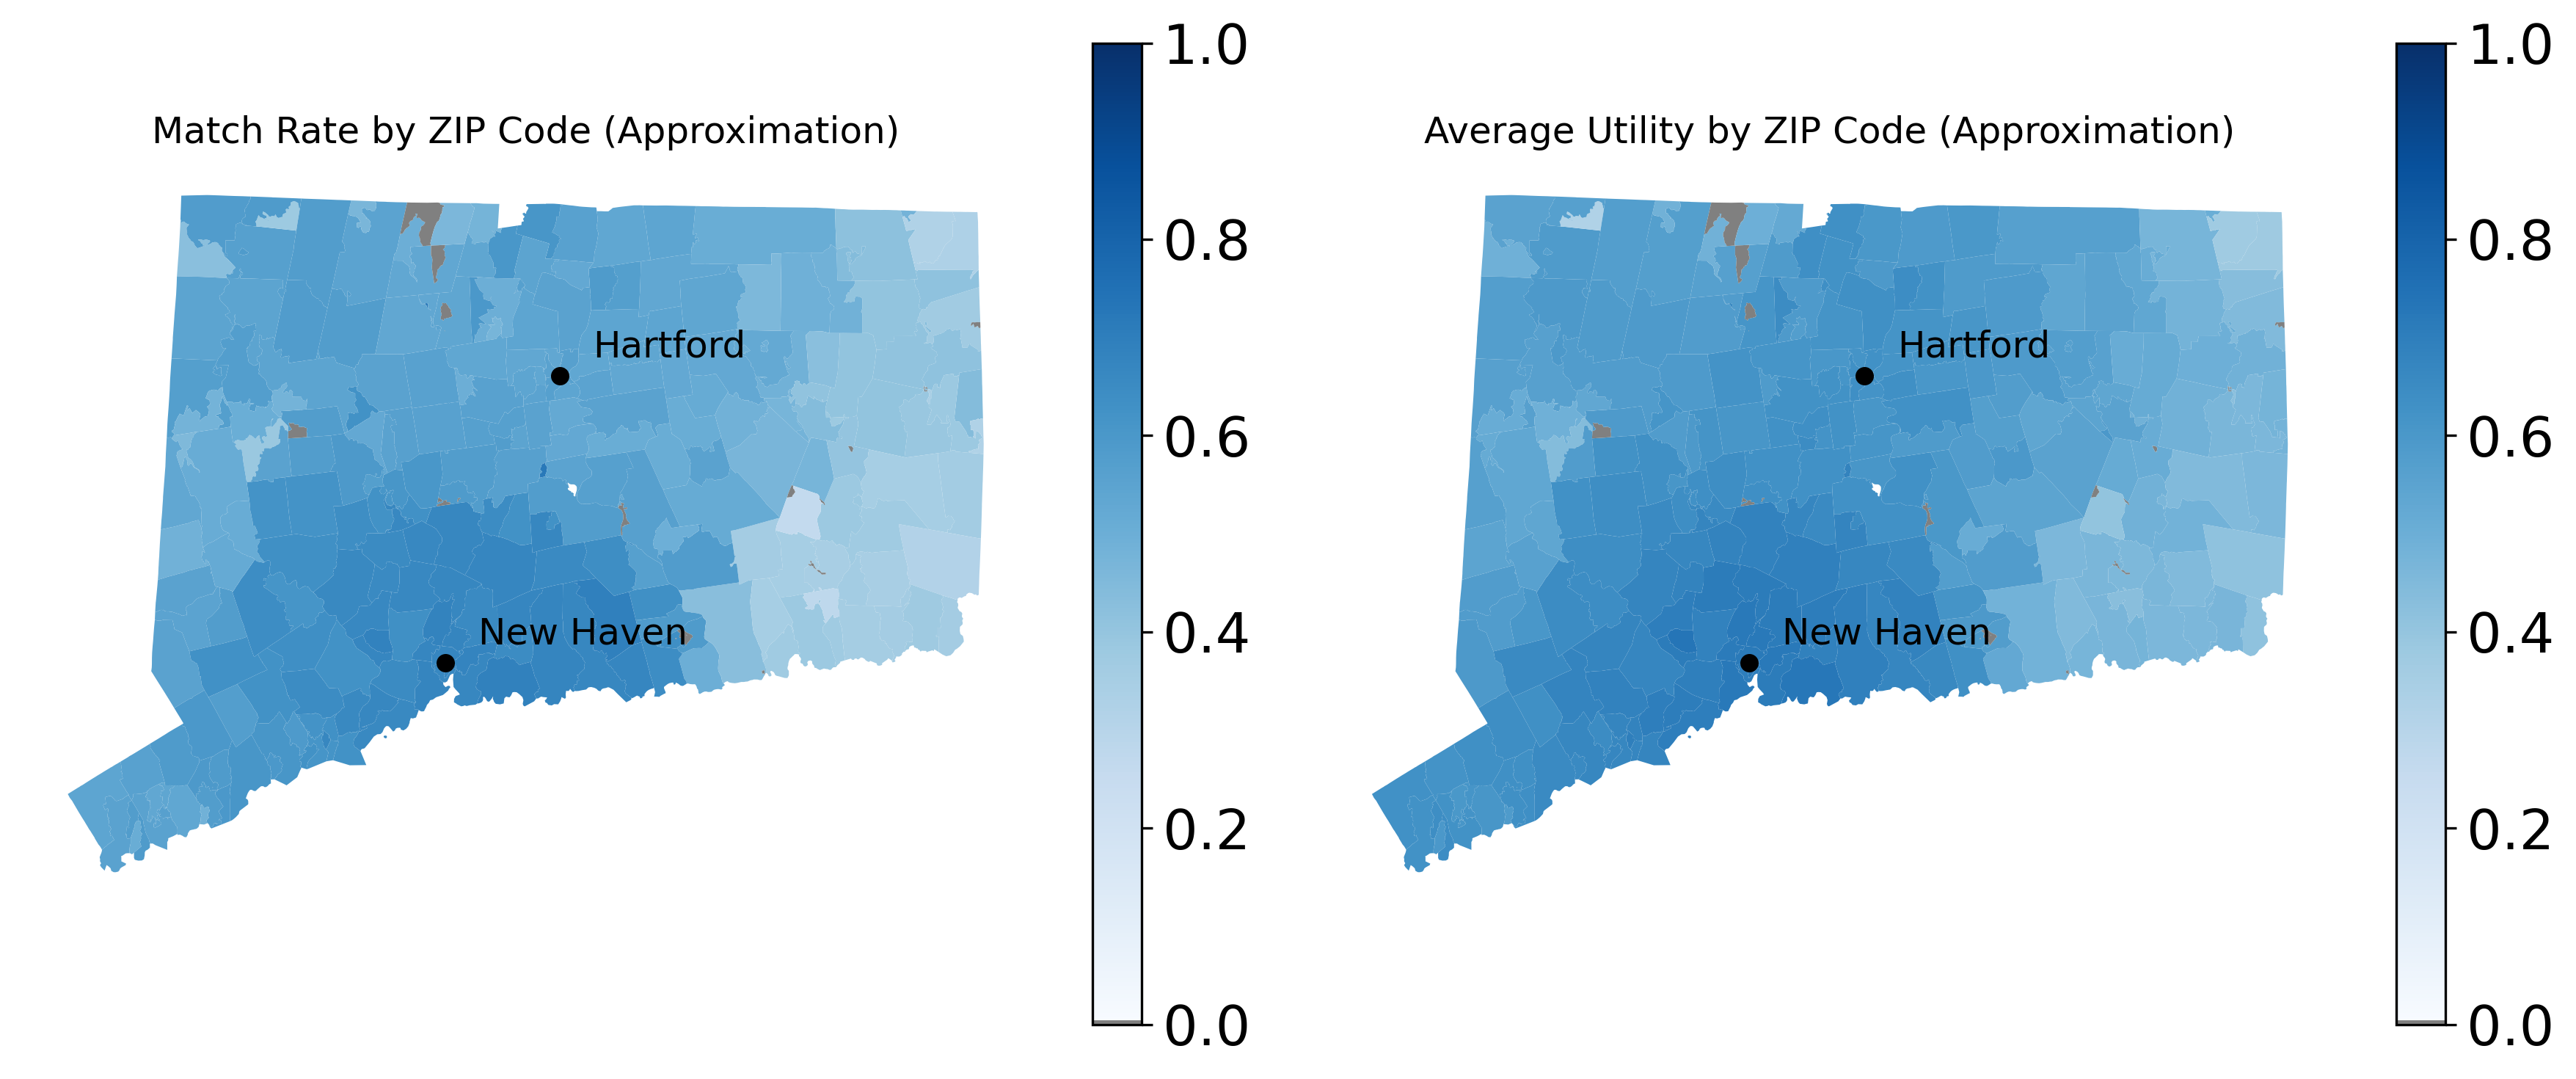

In [32]:
cmap_blue_red = mcolors.ListedColormap(
    ["grey"] + plt.cm.Blues(np.linspace(0, 1, 256)).tolist()
)


# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Match Rate (0 to 1)
ct_zipcodes.plot(column="match_rate", ax=axes[0], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"})
axes[0].set_title("Match Rate by ZIP Code (Approximation)")
axes[0].axis('off')

# Plot 2: Average Utility (0 to 1)
ct_zipcodes.plot(column="avg_utility", ax=axes[1], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"})
axes[1].set_title("Average Utility by ZIP Code (Approximation)")
axes[1].axis('off')

hartford_coords = (41.7637, -72.6851)  # Hartford, CT (latitude, longitude)
newhaven_coords = (41.3083, -72.9279)  # New Haven, CT (latitude, longitude)

for i in range(2):
# Plot dots for Hartford and New Haven
    axes[i].scatter(hartford_coords[1], hartford_coords[0], color="black", s=25, zorder=5)  # Hartford
    axes[i].scatter(newhaven_coords[1], newhaven_coords[0], color="black", s=25, zorder=5)  # New Haven

    axes[i].text(hartford_coords[1] + 0.07, hartford_coords[0] + 0.03, "Hartford", color="black", fontsize=12, zorder=6)
    axes[i].text(newhaven_coords[1] + 0.07, newhaven_coords[0] + 0.03, "New Haven", color="black", fontsize=12, zorder=6)


plt.tight_layout()
fig.savefig("../../results/figures/geographic_analysis_milp.pdf", dpi=300, bbox_inches='tight')
plt.show()


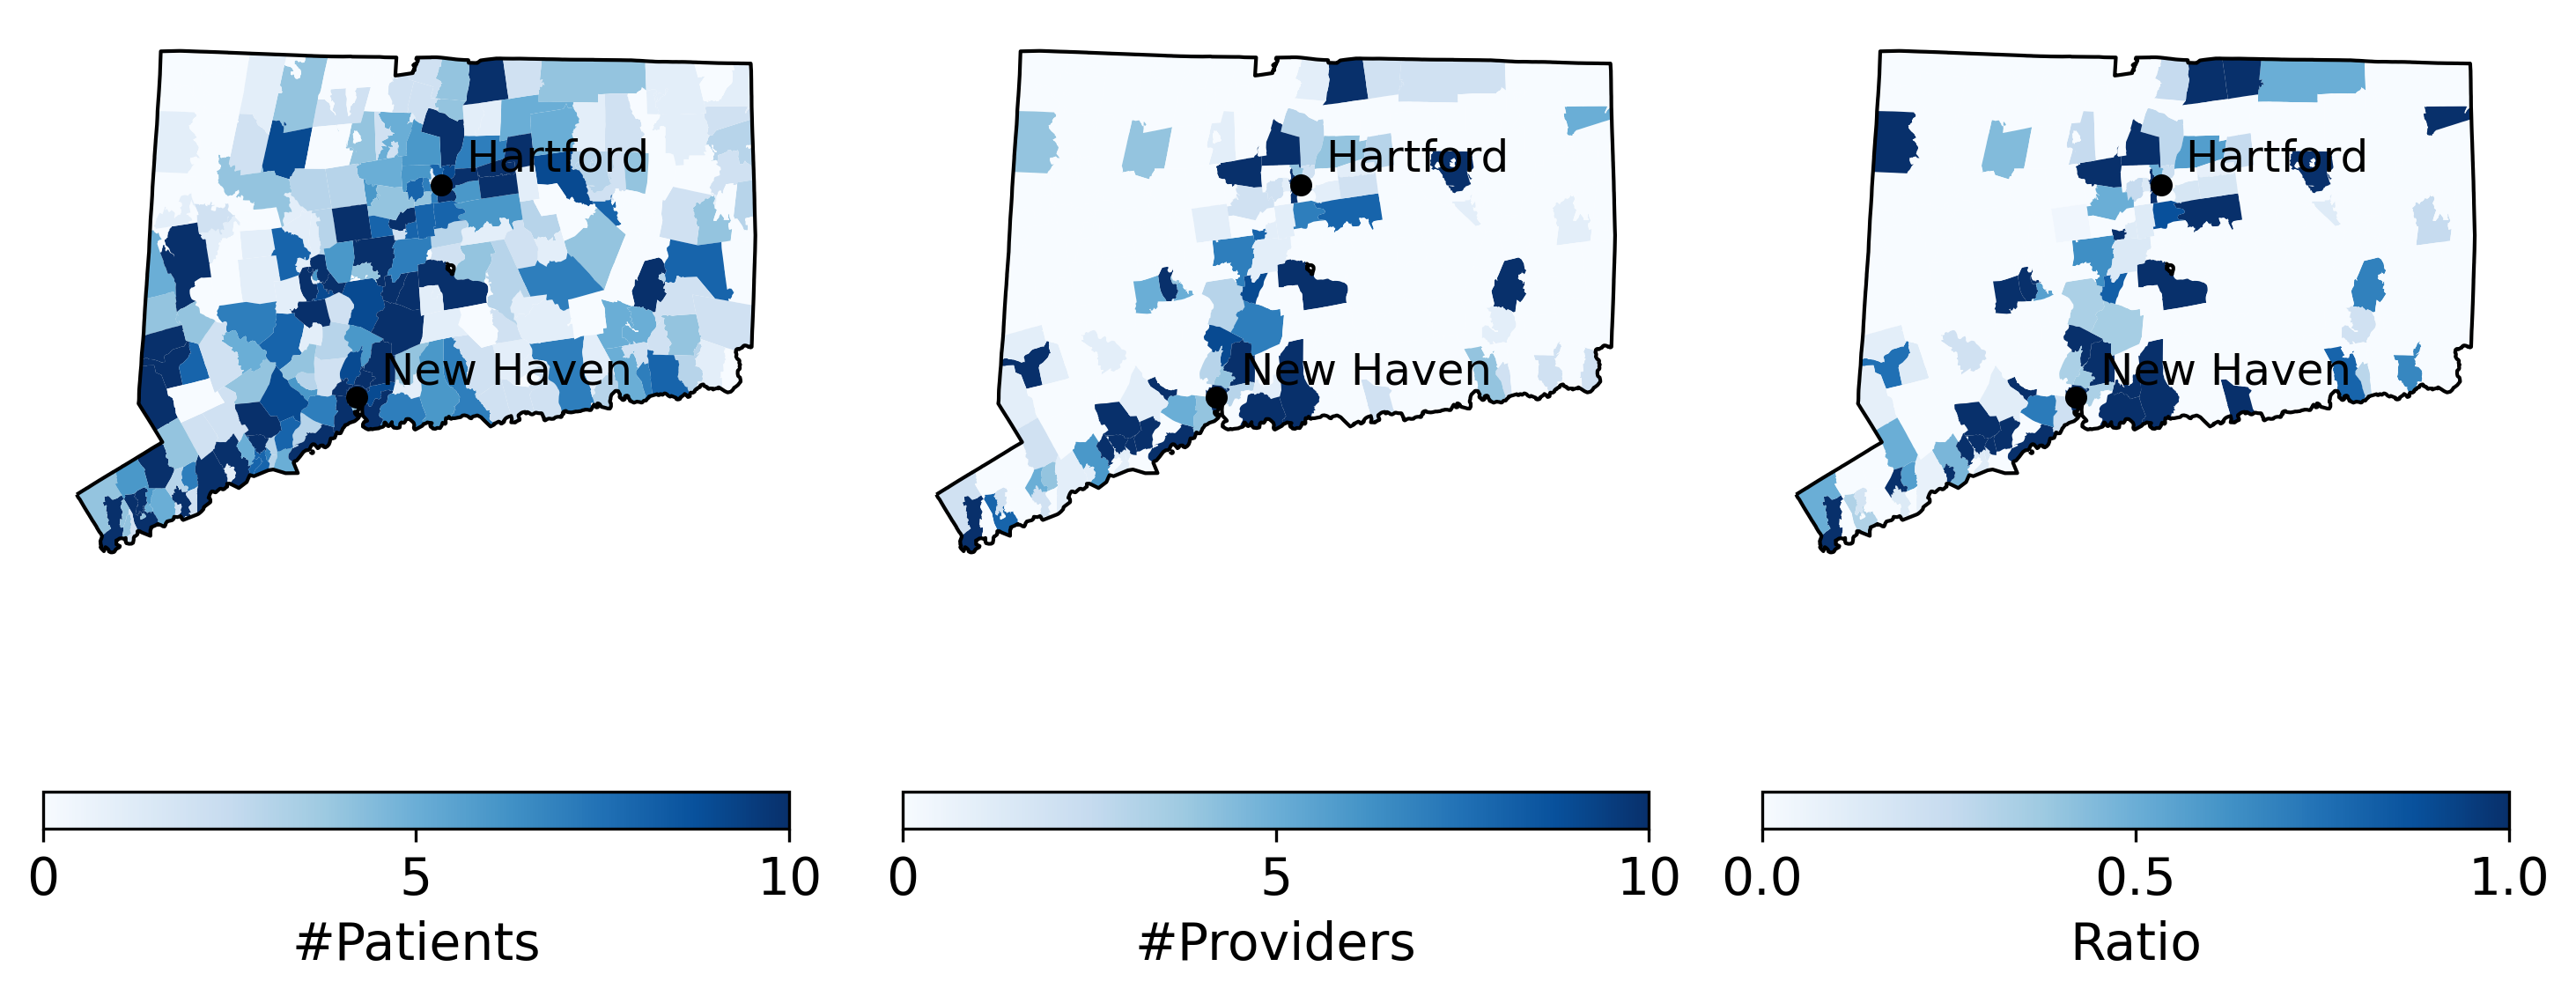

In [33]:
plot_dimensions = (1,3)
x_labels = [["Patients by ZIP","Providers by ZIP","Proivders/Patient"]]
y_labels =  [["","",""]]
x_ticks = [[[[0,20,40,60],[0,"20","40","60"]] for i in range(3)]]
sup_y_label = ""
overall_format = {'figsize':(10,6),
    'style_size': style_size,
    'has_grid': False, 
    'x_ticks': x_ticks,
    'label_size': 14,
}
fig,ax = create_axes(plot_dimensions,overall_format,y_labels=y_labels,x_labels=x_labels)

cmap = mcolors.ListedColormap(
   plt.cm.Blues(np.linspace(0, 1, 256)).tolist()
)

# Normalize the color range between 0 and 1

for i,column in enumerate(['patients','providers','ratio']):
    if i == 0:
        norm = mcolors.Normalize(vmin=0, vmax=10, clip=False)
    elif i == 1:
        norm = mcolors.Normalize(vmin=0, vmax=10, clip=False)
    elif i == 2:
        norm = mcolors.Normalize(vmin=0, vmax=1, clip=False)
    colorbar = ct_zipcodes.plot(
        column=column,
        cmap=cmap,
        norm=norm,
        legend=True,legend_kwds={"orientation": "horizontal"},
        ax=ax[0][i]
        
    )

    cbar = ax[0][i].get_figure().axes[-1]  # Access the colorbar axis
    cbar.tick_params(labelsize=14)
    if i == 0:
        cbar.set_xticks([0,5,10])
    elif i == 1:
        cbar.set_xticks([0,5,10])
    elif i == 2:
        cbar.set_xticks([0,0.5,1])
    
    if i == 0:
        cbar.set_xlabel("#Patients", fontsize=14)  # Increase font size for the label
    elif i == 1:
        cbar.set_xlabel("#Providers", fontsize=14)  # Increase font size for the label
    elif i == 2:
        cbar.set_xlabel("Ratio", fontsize=14)  # Increase font size for the label

    ct_outline = ct_zipcodes.dissolve()
    ct_outline.boundary.plot(ax=ax[0][i], color="black", linewidth=1)

    # Enhance the plot
    ax[0][i].axis("off")
    hartford_coords = (41.7637, -72.6851)  # Hartford, CT (latitude, longitude)
    newhaven_coords = (41.3083, -72.9279)  # New Haven, CT (latitude, longitude)

    # Plot dots for Hartford and New Haven
    ax[0][i].scatter(hartford_coords[1], hartford_coords[0], color="black", s=25, zorder=5)  # Hartford
    ax[0][i].scatter(newhaven_coords[1], newhaven_coords[0], color="black", s=25, zorder=5)  # New Haven

    ax[0][i].text(hartford_coords[1] + 0.07, hartford_coords[0] + 0.03, "Hartford", color="black", fontsize=12, zorder=6)
    ax[0][i].text(newhaven_coords[1] + 0.07, newhaven_coords[0] + 0.03, "New Haven", color="black", fontsize=12, zorder=6)


    # Show the plot
    plt.tight_layout()

fig.savefig("../../results/figures/patient_distro.pdf",dpi=300, bbox_inches='tight')


In [37]:
np.mean(all_patient_counts[0]),np.mean(all_ratios[0])

(np.float64(1.5714285714285714), np.float64(0.40586385024707444))

In [38]:
np.mean(all_patient_counts[3]),np.mean(all_ratios[3]),np.mean(all_ratios[3])/np.mean(all_ratios[4])

(np.float64(8.163109297052154),
 np.float64(0.49173351033593143),
 np.float64(0.9927373436152509))

In [9]:
util_online_scale = {}
std_online_scale = {}
online_scales = [0.1,0.25,0.5,0.75,0.9,1.0]
for online_scale in online_scales:
    results = get_results_matching_parameters("dynamic", "", {'num_patients': 1225,'online_arrival': True, 'average_distance': 20.2, 'online_scale': online_scale})
    all_avg = []

    for r in results:
        utilities = np.array(r['greedy_justified_patient_utilities'])[0]
        patient_orders = r['greedy_justified_patient_orders'][0]
        avg = np.array([utilities[i][patient_orders[i]] for i in range(len(utilities))])
        all_avg += avg.tolist() 
    all_avg = np.array(all_avg)
    avg_util = np.mean(all_avg,axis=0)
    std_util = np.std(all_avg,axis=0)

    window = 100
    avg_util = np.convolve(avg_util, np.ones(window)/window, mode='valid')
    std_util = np.convolve(std_util, np.ones(window)/window, mode='valid')
    util_online_scale[online_scale] = avg_util
    std_online_scale[online_scale] = std_util

In [10]:
util_online_scale[1][0],util_online_scale[1][800]

(np.float64(0.9824113450173494), np.float64(0.25043364408979546))

In [11]:
[(i,np.mean(util_online_scale[i])) for i in util_online_scale]

[(0.1, np.float64(0.3416451163894759)),
 (0.25, np.float64(0.509583462954883)),
 (0.5, np.float64(0.6851896038148394)),
 (0.75, np.float64(0.637599046027263)),
 (0.9, np.float64(0.6337040078507986)),
 (1.0, np.float64(0.6328643570142694))]

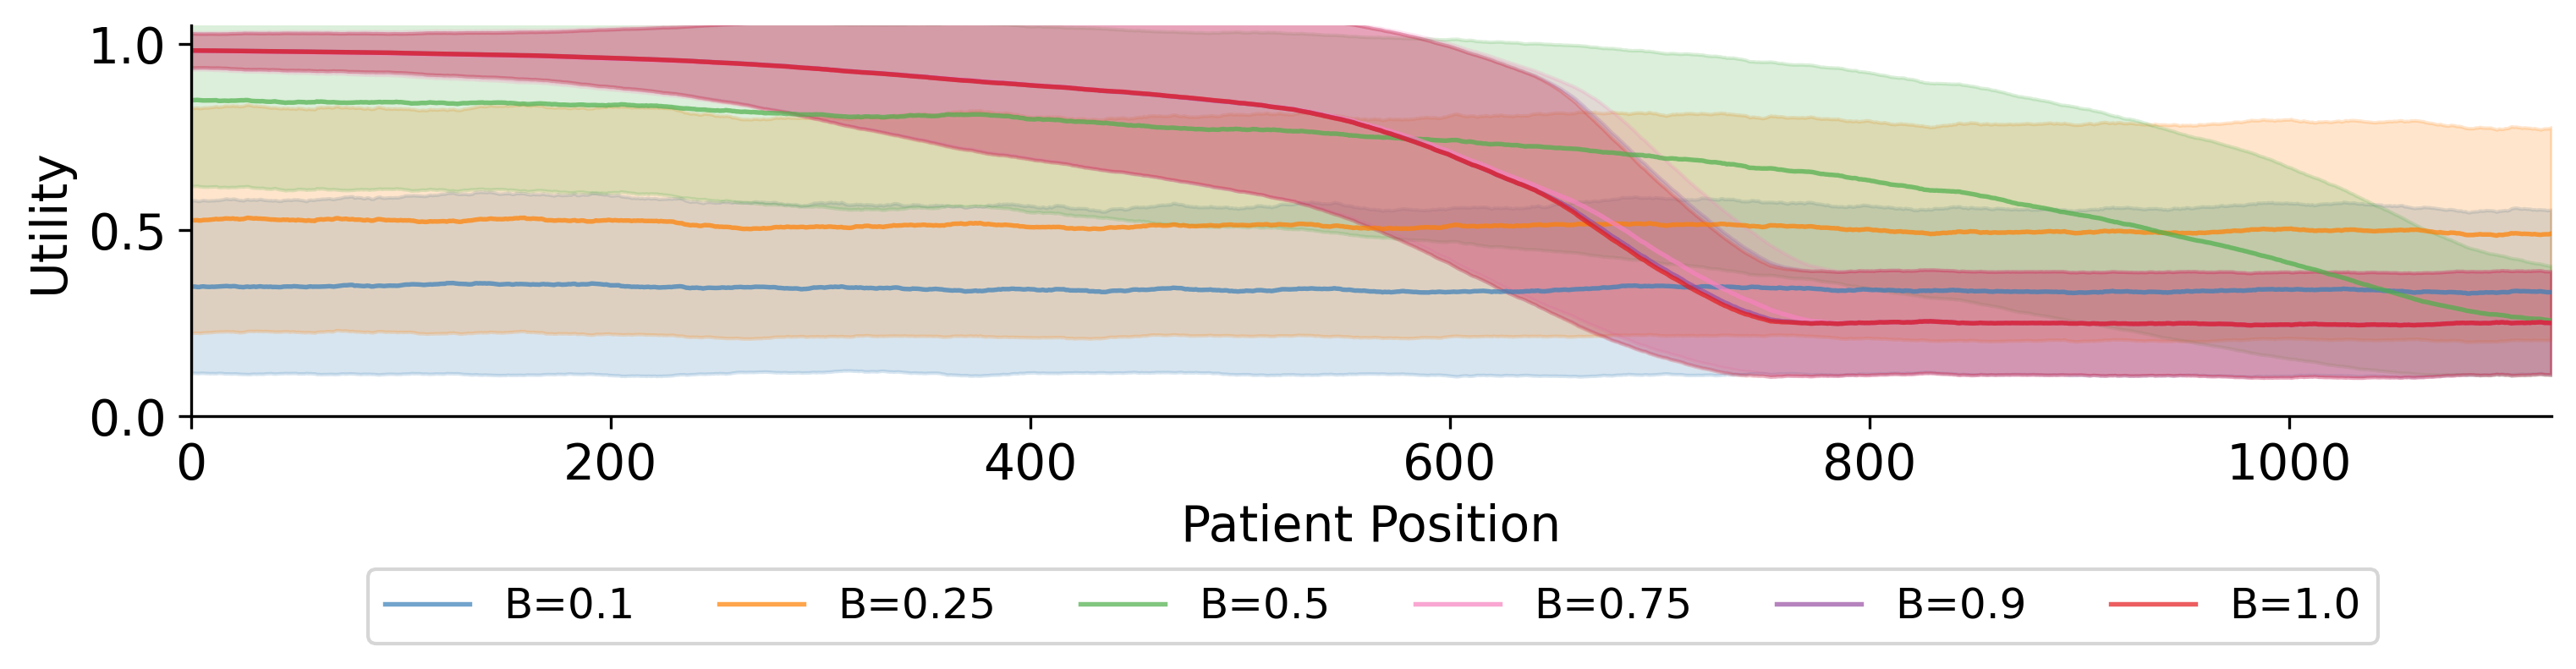

In [13]:
x_values = np.arange(len(avg_util))

# --- Plot ---
plot_dimensions = (1, 1)
x_labels = [["Patient Position"]]
y_labels = [["Utility"]]
overall_format = {
    'figsize': (12, 2),
    'style_size': 'paper',
    'hide_spines': True,
    'y_lim': [[[0, 1.05]]],
    'x_lim': [[[0, len(avg_util) - 1]]],
}

fig, ax = create_axes(plot_dimensions, overall_format, x_labels=x_labels, y_labels=y_labels)

# Line + scatter
line_format = {'color_palette': 'six_color', 'size': 10, 'linewidth': 1.3}
plot_line(ax[0][0], [x_values for i in range(len(online_scales))], [util_online_scale[s] for s in online_scales], [std_online_scale[s] for s in online_scales], ["B={}".format(s) for s in online_scales], line_format)

# Legend
legend_format = {
    'style_size': 'paper',
    'type': 'is_global',
    'loc': 'upper right',
    'ncol': 6,
    'bbox_to_anchor': (0.85, -0.15),
    'show_point': False,
    'fontsize': 12
}
create_legend(fig, ax, plot_dimensions, legend_format)

# Save
fig.savefig("../../results/figures/avg_utility_position_online.pdf",
            dpi=300, bbox_inches='tight')


In [46]:
# Get results from the new provider experiment
results = get_results_matching_parameters("dynamic", "", {'num_patients': 1225,'new_provider': True, 'average_distance': 20.2})  # Adjust folder/params as needed
params = results[0]['parameters']

# Collect utility distributions for switchers
before_utilities = {method: [] for method in methods}
after_utilities = {method: [] for method in methods}

for method in methods:
    utilities_key = f"{method}_patient_utilities"
    utilities = [r[utilities_key][0] for r in results if utilities_key in r] # Shape: (seeds, trials, patients, 2)

    # For each seed, trial, patient
    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            for patient_idx in range(len(utilities[seed_idx][trial_idx])):
                before = utilities[seed_idx][trial_idx][patient_idx][0]
                after = utilities[seed_idx][trial_idx][patient_idx][1]
                
                # Check if patient switched (utility changed)
                if abs(after - before) > 1e-6:  # Small epsilon for floating point comparison
                    before_utilities[method].append(before)
                    after_utilities[method].append(after)



In [47]:
[np.mean(after_utilities[i])/np.mean(before_utilities[i]) for i in before_utilities]

[np.float64(1.7951365007226343),
 np.float64(2.0044653817153746),
 np.float64(2.374630965521241),
 np.float64(2.0973846843799397),
 np.float64(1.803027919082749)]

In [54]:
num_methods = len(methods)

plot_dimensions = (1, num_methods)

x_labels = [["" for _ in range(num_methods)]]
y_labels = [["" for _ in range(num_methods)]]
titles   = [[method_labels[i] for i in range(num_methods)]]

overall_format = {
    "figsize": (2.0 * num_methods, 1.8),  # wider
    "style_size": "paper",
    "hide_spines": True,
    "constrained_layout": True,
    'x_lim': [[[0,1] for i in range(5)] for i in range(1)]
}

fig, ax = create_axes(
    plot_dimensions,
    overall_format,
    x_labels=x_labels,
    y_labels=y_labels,
    titles=titles,
)

colors = color_schemes["two_color_blue_green"]
offset = 0.18
width  = 0.28

# Shared x-limits
all_vals = np.concatenate([
    np.concatenate([before_utilities[m] for m in methods]),
    np.concatenate([after_utilities[m]  for m in methods]),
])
xlim = (all_vals.min(), all_vals.max())

for i, m in enumerate(methods):
    a = ax[0][i]

    bp = a.boxplot(
        [before_utilities[m], after_utilities[m]],
        positions=[+offset, -offset],  # Before on top
        widths=width,
        vert=False,
        patch_artist=True,
        showfliers=False,
        notch=True,
    )

    bp["boxes"][0].set_facecolor(colors[0])  # Before
    bp["boxes"][1].set_facecolor(colors[1])  # After

    a.set_yticks([])     # remove meaningless y ticks

# Figure-level legend (bottom center)
legend_handles = [
    patches.Patch(color=colors[0], label="Before"),
    patches.Patch(color=colors[1], label="After"),
]

fig.legend(
    handles=legend_handles,
    loc="lower center",
    ncol=2,
    frameon=False,
    bbox_to_anchor=(0.5, -0.25),
)

plt.tight_layout()
fig.savefig(
    "../../results/figures/switcher_utility_distribution.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


/tmp/ipykernel_1876262/3431445294.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


In [84]:
# Get results from the new provider experiment
results = get_results_matching_parameters("dynamic", "", {'new_provider': True, 'num_patients': 1225, 'average_distance': 20.2})
params = results[0]['parameters']

# Load patient and provider data
patient_file = f"../../data/patient_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"
provider_file = f"../../data/provider_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"

with open(patient_file, 'r') as f:
    patient_data = json.load(f)
with open(provider_file, 'r') as f:
    provider_data = json.load(f)

patient_zipcodes = [p['location'] for p in patient_data]

# Get the new provider's location for each trial
method = 'greedy_justified'  # Choose which method to visualize
new_providers_key = f"{method}_new_providers"
new_providers = results[0][new_providers_key]  # Shape: (seeds, trials)

# Get the most common new provider (or first one)
new_provider_idx = new_providers[0][0]  # First seed, first trial
new_provider_zipcode = get_zip(provider_data[new_provider_idx]['ZIP Code'])  # Take first 5 digits
new_provider_city = provider_data[new_provider_idx]['City/Town']

print(f"New provider location: {new_provider_city}, ZIP {new_provider_zipcode}")

# Calculate match rates by zipcode before and after
def calculate_match_rates_before_after(method, patient_zipcodes, num_providers):
    """Calculate match rate by zipcode for before/after new provider"""
    matches_before_by_zipcode = {}
    matches_after_by_zipcode = {}
    
    utilities_key = f"{method}_patient_utilities"
    chosen_providers_key = f"{method}_chosen_providers"
    
    utilities = [r[utilities_key][0] for r in results]  # Shape: (seeds, trials, patients, 2)
    chosen_providers = [r[chosen_providers_key][0] for r in results] # Shape: (seeds, trials, patients, 2)
    s = []
    t = []
    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            for patient_idx in range(len(utilities[seed_idx][trial_idx])):
                zipcode = patient_zipcodes[patient_idx]
                
                if zipcode not in matches_before_by_zipcode:
                    matches_before_by_zipcode[zipcode] = []
                    matches_after_by_zipcode[zipcode] = []
                
                # Before: check if provider is in [0, num_providers-1]
                provider_before = chosen_providers[seed_idx][trial_idx][patient_idx][0]
                matched_before = (provider_before >= 0 and provider_before < num_providers)
                
                # After: check if provider is in [0, num_providers] (includes new provider at index num_providers)
                provider_after = chosen_providers[seed_idx][trial_idx][patient_idx][1]
                matched_after = (provider_after >= 0 and provider_after < num_providers)


                matches_before_by_zipcode[zipcode].append(1 if matched_before else 0)
                matches_after_by_zipcode[zipcode].append(1 if matched_after else 0)
    
    # Calculate match rates
    match_rate_before = {z: np.mean(matches_before_by_zipcode[z]) for z in matches_before_by_zipcode}
    match_rate_after = {z: np.mean(matches_after_by_zipcode[z]) for z in matches_after_by_zipcode}
    match_rate_change = {z: match_rate_after[z] - match_rate_before[z] for z in match_rate_before}
    return match_rate_before, match_rate_after, match_rate_change
match_rate_before, match_rate_after, match_rate_change = calculate_match_rates_before_after(
    method, patient_zipcodes, params['num_providers']
)

# Load CT zipcode shapefile
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Add data to geodataframe
ct_zipcodes["match_rate_before"] = [match_rate_before.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_after"] = [match_rate_after.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_change"] = [match_rate_change.get(z, 0) for z in ct_zipcodes["ZCTA5CE10"]]

# Get the new provider's geometry for zooming
new_provider_geom = ct_zipcodes[ct_zipcodes["ZCTA5CE10"] == new_provider_zipcode]



New provider location: BRIDGEPORT, ZIP 06606


In [85]:
from matplotlib.cm import ScalarMappable

fig, axes = plt.subplots(1, 3, figsize=(12,4))

# Colormap
cmap_change = cmap_blue_red  # Red=decrease, Yellow=no change, Green=increase

# Plot 1: Match Rate Before
ct_zipcodes.plot(column="match_rate_before", ax=axes[0], legend=False, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"},legend_kwds={"shrink": 0.6})
axes[0].set_title(f"Match Rate Before New Provider")

axes[0].axis('off')

# Plot 2: Match Rate After
ct_zipcodes.plot(column="match_rate_after", ax=axes[1], legend=False, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"},legend_kwds={"shrink": 0.6})
axes[1].set_title(f"Match Rate After New Provider")
axes[1].axis('off')

# Plot 3: Change in Match Rate
ct_zipcodes.plot(column="match_rate_change", ax=axes[2], legend=False, cmap=cmap_change,
                 vmin=-0.05, vmax=0.05, missing_kwds={"color": "lightgrey"},legend_kwds={"shrink": 0.6})
axes[2].set_title(f"Change in Match Rate")
axes[2].axis('off')

# Mark new provider location on all plots
# if not new_provider_geom.empty:
#     for ax in axes:
#         new_provider_geom.plot(ax=ax, color='none', edgecolor='black', linewidth=3)
#         centroid = new_provider_geom.geometry.centroid.iloc[0]
#         ax.plot(centroid.x, centroid.y, 'r*', markersize=20, label='New Provider')

# # Optionally zoom in around the new provider
# if not new_provider_geom.empty:
#     bounds = new_provider_geom.total_bounds  # minx, miny, maxx, maxy
#     buffer = 0.3  # Adjust zoom level
#     for ax in axes:
#         ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
#         ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

cb1 = fig.colorbar(
    ScalarMappable(norm=Normalize(0, 1), cmap=cmap_blue_red),
    ax=axes[0],
    shrink=0.6,
    aspect=30
)
cb1.ax.tick_params(labelsize=12)

# Colorbar 2
cb2 = fig.colorbar(
    ScalarMappable(norm=Normalize(0, 1), cmap=cmap_blue_red),
    ax=axes[1],
    shrink=0.6,
    aspect=30
)
cb2.ax.tick_params(labelsize=12)

# Colorbar 3
cb3 = fig.colorbar(
    ScalarMappable(norm=Normalize(-0.05, 0.05), cmap=cmap_change),
    ax=axes[2],
    shrink=0.6,
    aspect=30
)
cb3.ax.tick_params(labelsize=12)


plt.tight_layout()
fig.savefig("../../results/figures/geographic_new_provider_impact.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [79]:
num_patients = 1225
num_providers = 700
results = get_results_matching_parameters("dynamic", "", {'new_provider': True, 'num_patients': 1225, 'average_distance': 20.2, 'online_scale': 1})
params = results[0]['parameters']

# Load patient and provider data
patient_file = f"../../data/patient_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"
provider_file = f"../../data/provider_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"

with open(patient_file, 'r') as f:
    patient_data = json.load(f)
with open(provider_file, 'r') as f:
    provider_data = json.load(f)

patient_zipcodes = [p['location'] for p in patient_data]

# Get the new provider's location for each trial
method = 'greedy_justified'  # Choose which method to visualize
new_providers_key = f"{method}_new_providers"
new_providers = results[0][new_providers_key]  # Shape: (seeds, trials)

# Get the most common new provider (or first one)
new_provider_idx = new_providers[0][0]  # First seed, first trial
new_provider_zipcode = get_zip(provider_data[new_provider_idx]['ZIP Code']) # Take first 5 digits
new_provider_city = provider_data[new_provider_idx]['City/Town']

matches_before_by_zipcode = {}
matches_after_by_zipcode = {}
method = 'greedy_justified'
utilities_key = f"{method}_patient_utilities"
chosen_providers_key = f"{method}_chosen_providers"

utilities = [r[utilities_key][0] for r in results] # Shape: (seeds, trials, patients, 2)
chosen_providers = [r[chosen_providers_key][0] for r in results]  # Shape: (seeds, trials, patients, 2)
for seed_idx in range(len(utilities)):
    for trial_idx in range(1):
        for patient_idx in range(len(utilities[seed_idx][trial_idx])):
            zipcode = patient_zipcodes[patient_idx]
            
            if zipcode not in matches_before_by_zipcode:
                matches_before_by_zipcode[zipcode] = []
                matches_after_by_zipcode[zipcode] = []
            
            # Before: check if provider is in [0, num_providers-1]
            provider_before = chosen_providers[seed_idx][trial_idx][patient_idx][0]
            matched_before = (provider_before >= 0 and provider_before < num_providers)
            
            # After: check if provider is in [0, num_providers] (includes new provider at index num_providers)
            provider_after = chosen_providers[seed_idx][trial_idx][patient_idx][1]
            matched_after = (provider_after >= 0 and provider_after < num_providers)

In [80]:
# Get results from the new provider experiment
results = get_results_matching_parameters("dynamic", "", {'new_provider': True, 'num_patients': 1225, 'average_distance': 20.2})
idx = 3
params = results[idx]['parameters']

# Load patient and provider data
patient_file = f"../../data/patient_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"
provider_file = f"../../data/provider_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"

with open(patient_file, 'r') as f:
    patient_data = json.load(f)
with open(provider_file, 'r') as f:
    provider_data = json.load(f)

patient_zipcodes = [p['location'] for p in patient_data]

# Get the new provider's location for each trial
method = 'greedy_justified'  # Choose which method to visualize
new_providers_key = f"{method}_new_providers"
new_providers = results[idx][new_providers_key]  # Shape: (seeds, trials)

# Get the most common new provider (or first one)
new_provider_idx = new_providers[0][0]  # First seed, first trial
new_provider_zipcode = get_zip(provider_data[new_provider_idx]['ZIP Code'])  # Take first 5 digits
new_provider_city = provider_data[new_provider_idx]['City/Town']

print(f"New provider location: {new_provider_city}, ZIP {new_provider_zipcode}")

# Calculate match rates by zipcode before and after
def calculate_match_rates_before_after(method, patient_zipcodes, num_providers):
    """Calculate match rate by zipcode for before/after new provider"""
    matches_before_by_zipcode = {}
    matches_after_by_zipcode = {}
    
    utilities_key = f"{method}_patient_utilities"
    chosen_providers_key = f"{method}_chosen_providers"
    
    utilities = results[idx][utilities_key]  # Shape: (seeds, trials, patients, 2)
    chosen_providers = results[idx][chosen_providers_key]  # Shape: (seeds, trials, patients, 2)
    for seed_idx in range(len(utilities)):
        for trial_idx in range(1):
            for patient_idx in range(len(utilities[seed_idx][trial_idx])):
                zipcode = patient_zipcodes[patient_idx]
                
                if zipcode not in matches_before_by_zipcode:
                    matches_before_by_zipcode[zipcode] = []
                    matches_after_by_zipcode[zipcode] = []
                
                # Before: check if provider is in [0, num_providers-1]
                provider_before = chosen_providers[seed_idx][trial_idx][patient_idx][0]
                matched_before = (provider_before >= 0 and provider_before < num_providers)
                
                # After: check if provider is in [0, num_providers] (includes new provider at index num_providers)
                provider_after = chosen_providers[seed_idx][trial_idx][patient_idx][1]
                matched_after = (provider_after >= 0 and provider_after < num_providers)


                matches_before_by_zipcode[zipcode].append(1 if matched_before else 0)
                matches_after_by_zipcode[zipcode].append(1 if matched_after else 0)
    
    # Calculate match rates
    match_rate_before = {z: np.mean(matches_before_by_zipcode[z]) for z in matches_before_by_zipcode}
    match_rate_after = {z: np.mean(matches_after_by_zipcode[z]) for z in matches_after_by_zipcode}
    match_rate_change = {z: match_rate_after[z] - match_rate_before[z] for z in match_rate_before}
    return match_rate_before, match_rate_after, match_rate_change
match_rate_before, match_rate_after, match_rate_change = calculate_match_rates_before_after(
    method, patient_zipcodes, params['num_providers']
)

# Load CT zipcode shapefile
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Add data to geodataframe
ct_zipcodes["match_rate_before"] = [match_rate_before.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_after"] = [match_rate_after.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_change"] = [match_rate_change.get(z, 0) for z in ct_zipcodes["ZCTA5CE10"]]

# Get the new provider's geometry for zooming
new_provider_geom = ct_zipcodes[ct_zipcodes["ZCTA5CE10"] == new_provider_zipcode]



New provider location: NEW HAVEN, ZIP 06519


/tmp/ipykernel_1876262/2539680293.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = new_provider_geom.geometry.centroid.iloc[0]
/tmp/ipykernel_1876262/2539680293.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = new_provider_geom.geometry.centroid.iloc[0]
/tmp/ipykernel_1876262/2539680293.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = new_provider_geom.geometry.centroid.iloc[0]


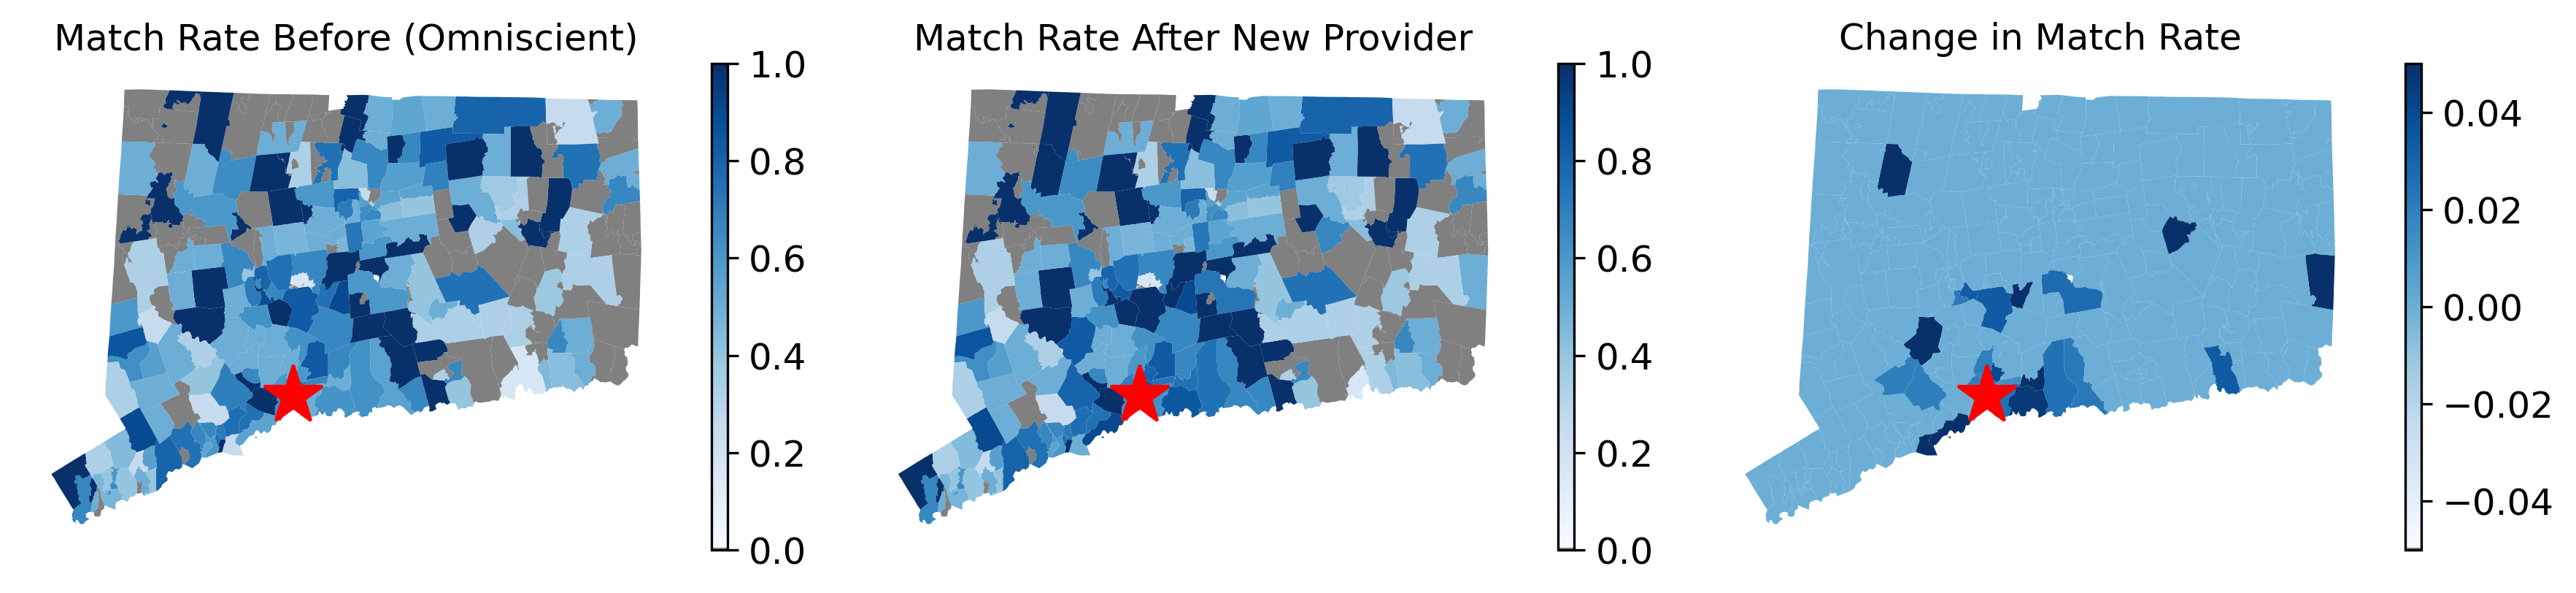

In [82]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

# Colormap
cmap_blue_red = mcolors.ListedColormap(
    ["grey"] + plt.cm.Blues(np.linspace(0, 1, 256)).tolist()
)
cmap_change = mcolors.ListedColormap(
    ["grey"] + plt.cm.Blues(np.linspace(0, 1, 256)).tolist()
)  # Red=decrease, Yellow=no change, Green=increase

# Plot 1: Match Rate Before
ct_zipcodes.plot(column="match_rate_before", ax=axes[0], legend=False, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"})
axes[0].set_title(f"Match Rate Before (Omniscient)")
axes[0].axis('off')

# Plot 2: Match Rate After
ct_zipcodes.plot(column="match_rate_after", ax=axes[1], legend=False, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"})
axes[1].set_title(f"Match Rate After New Provider")
axes[1].axis('off')

# Plot 3: Change in Match Rate
ct_zipcodes.plot(column="match_rate_change", ax=axes[2], legend=False, cmap=cmap_change,
                 vmin=-0.25, vmax=0.25, missing_kwds={"color": "lightgrey"})
axes[2].set_title(f"Change in Match Rate")
axes[2].axis('off')

if not new_provider_geom.empty:
    for ax in axes:
        new_provider_geom.plot(ax=ax, color='none', edgecolor='black', linewidth=3)
        centroid = new_provider_geom.geometry.centroid.iloc[0]
        ax.plot(centroid.x, centroid.y, 'r*', markersize=20, label='New Provider')


cb1 = fig.colorbar(
    ScalarMappable(norm=Normalize(0, 1), cmap=cmap_blue_red),
    ax=axes[0],
    shrink=0.6,
    aspect=30
)
cb1.ax.tick_params(labelsize=12)

# Colorbar 2
cb2 = fig.colorbar(
    ScalarMappable(norm=Normalize(0, 1), cmap=cmap_blue_red),
    ax=axes[1],
    shrink=0.6,
    aspect=30
)
cb2.ax.tick_params(labelsize=12)

# Colorbar 3
cb3 = fig.colorbar(
    ScalarMappable(norm=Normalize(-0.05, 0.05), cmap=cmap_change),
    ax=axes[2],
    shrink=0.6,
    aspect=30
)
cb3.ax.tick_params(labelsize=12)


# # Optionally zoom in around the new provider
# if not new_provider_geom.empty:
#     bounds = new_provider_geom.total_bounds  # minx, miny, maxx, maxy
#     buffer = 0.7  # Adjust zoom level
#     for ax in axes:
#         ax.set_xlim(bounds[0] - buffer, bounds[2] + buffer)
#         ax.set_ylim(bounds[1] - buffer, bounds[3] + buffer)

plt.tight_layout()
fig.savefig("../../results/figures/geographic_new_provider_single.pdf", dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# === Get Performance vs Average Distance ===
average_distance_values = [1, 5, 10, 15, 20, 25, 30]

# Store results for each method
distance_avg_utilities = {method: [] for method in methods}
distance_avg_utilities_std = {method: [] for method in methods}

for avg_dist in average_distance_values:
    print(avg_dist)
    results = get_results_matching_parameters("ablations", "", {
        'num_patients': 1225,
        'num_providers': 700,
        'noise': 0.1,
        'average_distance': avg_dist
    })
    
    for method in methods:
        utilities_key = f"{method}_patient_utilities"
        utilities = [r[utilities_key][0] for r in results]
        
        # Flatten: [seeds][trials][patients]
        all_utilities = []
        for seed_idx in range(len(utilities)):
            for trial_idx in range(len(utilities[seed_idx])):
                all_utilities.extend(utilities[seed_idx][trial_idx])
        
        distance_avg_utilities[method].append(np.mean(all_utilities))
        distance_avg_utilities_std[method].append(np.std(all_utilities) / np.sqrt(len(all_utilities)))

# === Get Geographic Data ===
def calculate_match_rates_by_zipcode(results, patient_zipcodes, num_providers, method='omniscient_optimal'):
    """Calculate match rate by zipcode"""
    matches_by_zipcode = {}
    
    utilities_key = f"{method}_patient_utilities"
    chosen_providers_key = f"{method}_chosen_providers"
    
    utilities = [r[utilities_key][0] for r in results]
    chosen_providers = [r[chosen_providers_key][0] for r in results]
    
    for seed_idx in range(len(utilities)):
        for trial_idx in range(len(utilities[seed_idx])):
            for patient_idx in range(len(utilities[seed_idx][trial_idx])):
                zipcode = patient_zipcodes[patient_idx]
                provider = chosen_providers[seed_idx][trial_idx][patient_idx]
                
                if zipcode not in matches_by_zipcode:
                    matches_by_zipcode[zipcode] = []
                
                # Check if matched (provider in [0, num_providers-1])
                matched = (provider >= 0 and provider < num_providers)
                matches_by_zipcode[zipcode].append(1 if matched else 0)
    
    # Calculate match rates
    match_rate = {z: np.mean(matches_by_zipcode[z]) for z in matches_by_zipcode}
    return match_rate

# Get results for distance=1 and distance=30
results_dist1 = get_results_matching_parameters("ablations", "", {
    'num_patients': 1225,
    'num_providers': 700,
    'noise': 0.1,
    'average_distance': 1
})


results_dist30 = get_results_matching_parameters("ablations", "", {
    'num_patients': 1225,
    'num_providers': 700,
    'noise': 0.1,
    'average_distance': 5
})

# Load patient data
params = results_dist1[0]['parameters']
patient_file = f"../../data/patient_data_{params['seed']}_{params['num_patients']}_{params['num_providers']}_comorbidity.json"
with open(patient_file, 'r') as f:
    patient_data = json.load(f)
patient_zipcodes = [p['location'] for p in patient_data]

# Calculate match rates for both distances (using omniscient policy)
match_rate_dist1 = calculate_match_rates_by_zipcode(results_dist1, patient_zipcodes, params['num_providers'], 'greedy_justified')
match_rate_dist30 = calculate_match_rates_by_zipcode(results_dist30, patient_zipcodes, params['num_providers'], 'greedy_justified')

# Calculate change
match_rate_change = {z: match_rate_dist30.get(z, 0) - match_rate_dist1.get(z, 0) 
                     for z in set(list(match_rate_dist1.keys()) + list(match_rate_dist30.keys()))}

# Load CT zipcode shapefile
ct_zipcodes = gpd.read_file("../../data/ct.geojson")

# Add data to geodataframe
ct_zipcodes["match_rate_dist1"] = [match_rate_dist1.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_dist30"] = [match_rate_dist30.get(z, -1) for z in ct_zipcodes["ZCTA5CE10"]]
ct_zipcodes["match_rate_change"] = [match_rate_change.get(z, 0) for z in ct_zipcodes["ZCTA5CE10"]]



1
5
10
15
20
25
30


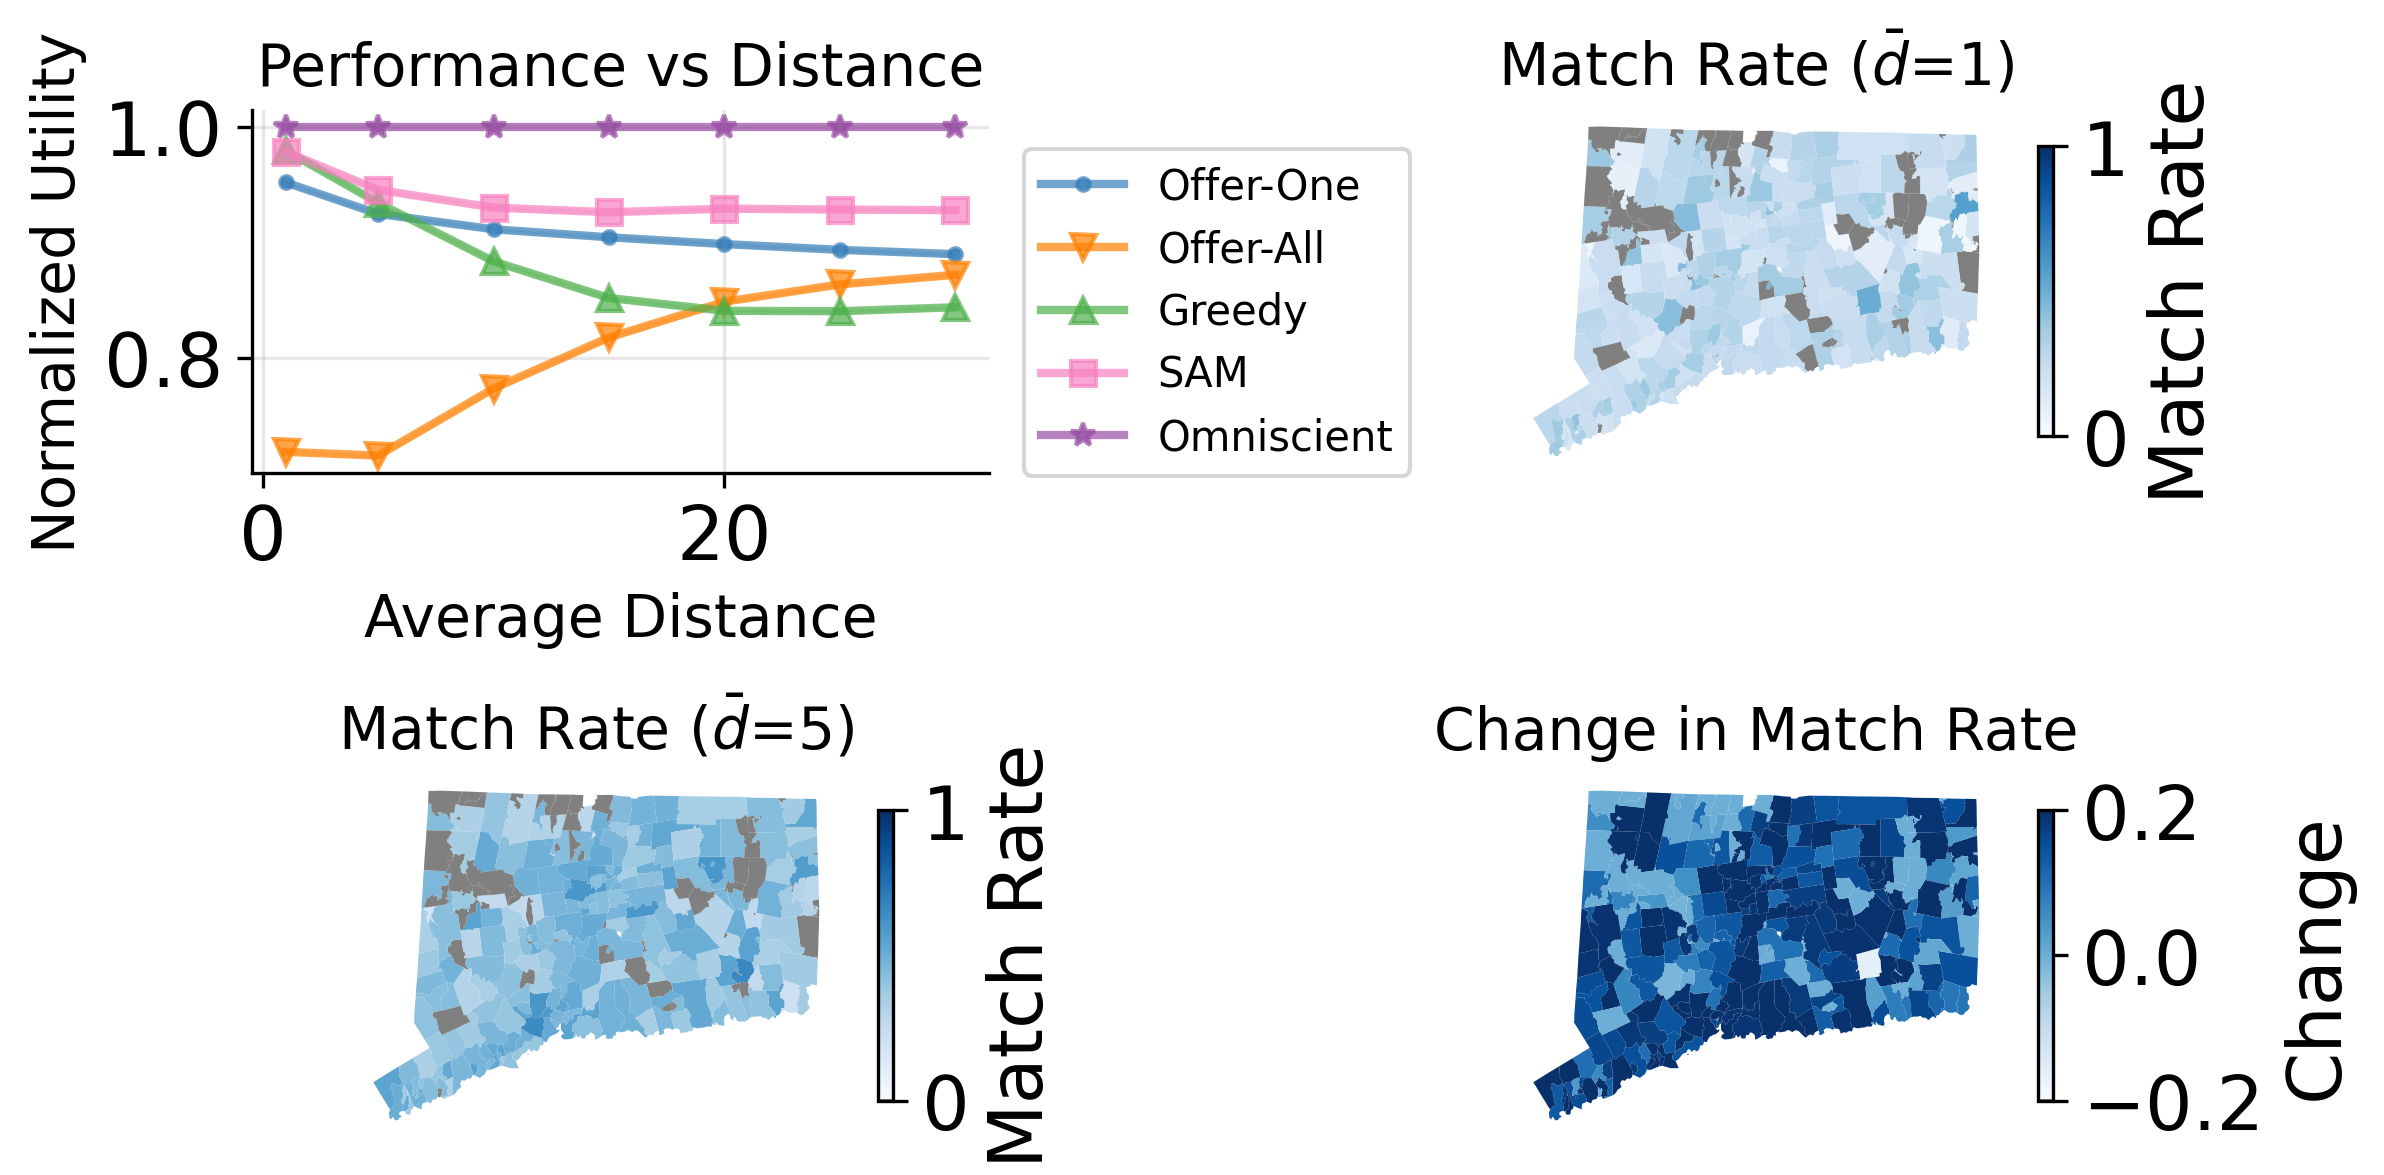

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(8, 4))
cmap_blue_red = mcolors.ListedColormap(
    ["grey"] + plt.cm.Blues(np.linspace(0, 1, 256)).tolist()
)

# Plot 1: Performance Line Graph
line_format = {
    'color_palette': 'six_color',
    'linewidth': 2,
}

x_values_distance = [average_distance_values for _ in methods]
y_values_distance = [np.array(distance_avg_utilities[method])/np.array(distance_avg_utilities[methods[-1]]) for method in methods]
y_confidence_distance = [distance_avg_utilities_std[method] for method in methods]

for i, method in enumerate(methods):
    axes[0][0].plot(x_values_distance[i], y_values_distance[i], label=method_labels[i], 
                 linewidth=2, color=color_schemes['six_color'][i], marker=markers[i])
    axes[0][0].fill_between(x_values_distance[i], 
                         np.array(y_values_distance[i]) - np.array(y_confidence_distance[i]),
                         np.array(y_values_distance[i]) + np.array(y_confidence_distance[i]),
                         alpha=0.2, color=color_schemes['six_color'][i])

axes[0][0].set_xlabel("Average Distance", fontsize=14)
axes[0][0].set_ylabel("Normalized Utility", fontsize=14)
axes[0][0].set_title("Performance vs Distance", fontsize=14)
axes[0][0].spines['top'].set_visible(False)
axes[0][0].spines['right'].set_visible(False)
axes[0][0].grid(True, alpha=0.3)
axes[0][0].legend(fontsize=10, loc='upper right',ncol=1,bbox_to_anchor=(1.6, 0.95))

# Colormap
cmap_change = mcolors.ListedColormap(
   plt.cm.Blues(np.linspace(0, 1, 256)).tolist()
)

# Plot 2: Distance=1
ct_zipcodes.plot(column="match_rate_dist1", ax=axes[0][1], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"},
                 legend_kwds={'label': 'Match Rate', 'shrink': 0.8})
axes[0][1].set_title("Match Rate ($\\bar{d}$=1)", fontsize=14)
axes[0][1].axis('off')

# Plot 3: Distance=30
ct_zipcodes.plot(column="match_rate_dist30", ax=axes[1][0], legend=True, cmap=cmap_blue_red,
                 vmin=0, vmax=1, missing_kwds={"color": "lightgrey"},
                 legend_kwds={'label': 'Match Rate', 'shrink': 0.8})
axes[1][0].set_title("Match Rate ($\\bar{d}$=5)", fontsize=14)
axes[1][0].axis('off')

# Plot 4: Change
ct_zipcodes.plot(column="match_rate_change", ax=axes[1][1], legend=True, cmap=cmap_blue_red,
                 vmin=-0.2, vmax=0.2, missing_kwds={"color": "lightgrey"},
                 legend_kwds={'label': 'Change', 'shrink': 0.8})
axes[1][1].set_title("Change in Match Rate", fontsize=14)
axes[1][1].axis('off')

plt.tight_layout()
fig.savefig("../../results/figures/distance_analysis_combined.pdf", dpi=300, bbox_inches='tight')
plt.show()
